In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import os
import sys

import btk
import btk.plot_utils
import btk.survey
import btk.draw_blends
import btk.catalog
import btk.sampling_functions
import astropy.table

import pyfftw.interfaces.numpy_fft as fft
import pyfftw
import galsim


from scripts.BTK_generator import BTK_blend_generator as btk_generator
from scripts.FFT_calcs import FFT_IFFT_calc 

**Work for tomorrow:**
1. Calculate the FT of the general non-rotated equation by hand and then code it up to see if it matchs what I get from `fft.fft2` (This is to see if there is something wrong with the basic form of the general equation for the rotated general equation).
2. Fix the equation for the analytical FT of the rotated equation
3. See how the shear and magnification are parameterized for $C$ or $C^{-1}$ (how is the spinor defined)
4. Incorporate shear into the rotated gaussian
5. See how noise affects the FT of these gaussians.

# 0. Goal of this Notebook

David said it would be good to better understand what was happening with the FT, so he suggested writing in code & by hand what the FT of a round 2D gaussian and an elliptical 2D gaussian is.

This notebook is the code portion of this task. 

**Work for next time:**
1. Might be good to make my own function for 2D gaussian that has the ability to create an elliptical gaussian. Do the FT of this, so I know what to expect
2. Compare what I got in (1.) with the answers by-hand
3. Do what I did in (1.), but using `GalSim`. I already have the `Galsim` 2D round gaussian, but I'm unsure what exactly David wanted from me when he was representing the elliptical galaxy in terms of $\sigma_1, \sigma_2, \rho$. I know I can represent it in terms of the reduced shear components $g_1, g_2, \sigma$ as in the photo ($\sigma \rightarrow e \hspace{02mm} \text{in `galsim`}$). And I know `GalSim` has this functionality, so would be good to do it in both ways potentially.

**NOTE:** This [wiki](https://en.wikipedia.org/wiki/Gravitational_lensing_formalism#Measures_of_ellipticity) page may be useful for understanding exactly what is happening/how shear is defined. But note that the `galsim` implementation of shear is different than is used in papers. For the version of shear that changes the shape of the object we want to use `lens` in `GalSim`.

# 1. Gaussians "by-hand"

General equation for a non-rotated 2D Gaussian: $$f(x,y) = A \text{ exp}\Big(-\frac{(x-x_0)^2}{2\sigma_x^2} - \frac{(y-y_0)^2}{2\sigma_y^2} \Big)$$

General equation for 2D Gaussian (includes rotation): $$f(x,y) = A \text{ exp}\Big(-\frac{(x-x_0)^2}{2\sigma_x^2(1-\rho^2)} - \frac{(y-y_0)^2}{2\sigma_y^2(1-\rho^2)} + \frac{(x-x_0)(y-y_0)\rho}{\sigma_x\sigma_y(1-\rho^2)}\Big)$$

I'll be using the equation that includes rotations in the code because we can create a non-rotated 2D gaussian by setting $\rho = 0$.


In [2]:
def gauss_2d(x0=0,
                y0=0,
                sigma_x=1.0,
                sigma_y=1.0,
                rho=0.5,
                A=1,
                N=128):
    '''
    General function to calculate 2D gaussian. Allows for circular, elliptical,
    rotated, and off-centered gaussians. The values of the Gaussian function are
    calculated by the given positions in the x and y meshgrid.
    
    Args:
    -----
        x: np.ndarray
            Matrix of the x-coordinates that make up the x-coordinates of each point in 
            the meshgrid. 
            NOTE: In a meshgrid a single point has 2 coordinates ie. (x,y)
        y: np.ndarray
            Matrix of the y-coordinates that make up the y-coordinates of each point in 
            the meshgrid.
            NOTE: In a meshgrid a single point has 2 coordinates ie. (x,y)
        x0: int 
            The x-coordinate of the center of the Gaussian.
            Defaults to 0.
        y0: int
            The y-coordinate of the center of the Gaussian.
        rho: float
            The correlation coefficient. Measure of direction and magnitude of stretch/
            rotation. Values must be between [-1,1].
            Defaults to 0.5.
        sigma_x: float
            The width of the gaussian in the x-direction.
            Defaults to 1.0
        sigma_y: float
            The width of the gaussian in the y-direction.
            Defaults to 1.0
        A: int
            The amplitude or "height" of the Gaussian.
        N: int
            Number of samples to create.
            E.g. if N=128 we'll create a meshgrid that is (128,128) and thus return
            an (128,128) Gaussian image.
            Defaults to 128.
            
            
    Returns:
    --------
        gauss: np.ndarray
            The array containing the gaussian function evaluated at each point
            in the meshgrid. I.e. returns the image of the Gaussian.
    '''
    x = np.linspace(-10,10,N)
    y = np.linspace(-10,10,N)
    Xg, Yg = np.meshgrid(x, y)

    norm = 1 / (2*np.pi * sigma_x * sigma_y * np.sqrt(1-rho**2))
    exp_x = -(Xg-x0)**2 /(2*sigma_x**2 * (1-rho**2))
    exp_y = -(Yg-y0)**2 / (2*sigma_y**2 * (1-rho**2))
    exp_xy = (Xg-x0)*(Yg-y0)*rho / (sigma_x*sigma_y * (1-rho**2))
    
    rot_gauss = norm * np.exp(exp_x + exp_y + exp_xy)

    return rot_gauss

def DFT_calc(img=None,
               x0=0,
               y0=0,
               sigma_x=1.0,
               sigma_y=1.0,
               rho=0.5,
               A=1,
               N=128,
               FFT=True):
    """
    Function that computes the FT via the DFT matrix. This is not optimal,
    one should use the FFT algorithm to compute the DFT, but for learning purposes
    we use this to better understand the FT.
    
    This is practice in understanding how the FFT algorithm works.
    Note that the output of the `DFT(input) == fft.fft2(input)`
    
    Args:
    -----
        x0: int 
            The x-coordinate of the center of the Gaussian.
            Defaults to 0.
        y0: int
            The y-coordinate of the center of the Gaussian.
        rho: float
            The correlation coefficient. Measure of direction and magnitude of stretch/
            rotation. Values must be between [-1,1].
            Defaults to 0.5.
        sigma_x: float
            The width of the gaussian in the x-direction.
            Defaults to 1.0
        sigma_y: float
            The width of the gaussian in the y-direction.
            Defaults to 1.0
        A: int
            The amplitude or "height" of the Gaussian.
        N: int
            Number of samples to create.
            E.g. if N=128 we'll create a meshgrid that is (128,128) and thus return
            an (128,128) Gaussian image.
            Defaults to 128.
        FFT: bool
            The value that sets if the function should do DFT or IDFT.
            
    Returns:
    -------
    """
    # Create Gaussian
    gauss = gauss_2d(x0=x0,
                    y0=y0,
                    sigma_x=sigma_x,
                    sigma_y=sigma_y,
                    rho=rho,
                    A=A)

    #DFT matrix calc
    n=128
    w = np.exp(-1j * 2 * np.pi / n)
    J, K = np.meshgrid(np.arange(n), np.arange(n))
    DFT_mat = np.power(w, J*K)
    
    if FFT==True:
        # Create empty arrays for use in DFT calc
        DFT_y = np.zeros((n,n), dtype=np.complex128)
        DFT = np.zeros((n,n), dtype=np.complex128)

        # FFT of row
        for i in range(n):
            DFT_y[i,:] += np.dot(DFT_mat, gauss[i,:])

        ## FFT of cols of resulting transformed matrix
        for j in range(n):
            DFT[:,j] += np.dot(DFT_mat, DFT_y[:,j])

        # Center the lowest frequencies in the center of the image
        DFT = np.fft.fftshift(DFT)
        
        return gauss, DFT
        
    else:
        
        w = np.exp(1j * 2 * np.pi / n)
        J, K = np.meshgrid(np.arange(n), np.arange(n))
        IDFT_mat = np.power(w, J*K)
        
        # Create empty arrays for use in DFT calc
        IDFT_y = np.zeros((n,n), dtype=np.complex128)
        IDFT = np.zeros((n,n), dtype=np.complex128)

        # FFT of row
        for i in range(n):
            IDFT_y[i,:] += np.dot(IDFT_mat, img[i,:])

        ## FFT of cols of resulting transformed matrix
        for j in range(n):
            IDFT[:,j] += np.dot(IDFT_mat, IDFT_y[:,j])

        # Center the lowest frequencies in the center of the image
#         IDFT = np.fft.fftshift(IDFT)   
        return IDFT

## 1.1 Round/Elliptical Gaussians FT

[Bruntons notebook](https://github.com/dynamicslab/databook_python/blob/master/CH02/CH02_SEC06_1_2DFFT.ipynb)

### 1.1.1 Analytical Expression for FT

Start with this equation: $$f(x,y) = A \text{ exp}\Big(-\frac{(x-x_0)^2}{2\sigma_x^2(1-\rho^2)} - \frac{(y-y_0)^2}{2\sigma_y^2(1-\rho^2)} + \frac{(x-x_0)(y-y_0)\rho}{\sigma_x\sigma_y(1-\rho^2)}\Big)$$

set $\rho=0$ to get it in the non-rotated form and then set $x_0=0, y_0=0$ for simplifcation and we get: $$f(x,y) = A \text{ exp}\Big(-\frac{x^2}{2\sigma_x^2} - \frac{y^2}{2\sigma_y^2} \Big)$$


where $$A = \frac{1}{2\pi \sigma_x \sigma_y}$$ so, we get:

$$f(x,y) =  \frac{1}{2\pi \sigma_x \sigma_y} \text{ exp}\Big(-\frac{x^2}{2\sigma_x^2} - \frac{y^2}{2\sigma_y^2} \Big)$$



Next, we do the FT and we should get: $$\hat{f}(u,v) = \sigma_x^2 \sigma_y^2 \text{exp}\Big(-2\pi^2 (u^2 \sigma_x^2 + v^2 \sigma_y^2)\Big)$$



In [3]:
def analytical_nonrot_gauss(sigma_x=1.0,
                            sigma_y=1.0,
                            A=1):
    """
    Function that calculates the FT of a non-rotated 2D Gaussian using the
    analytical solution I calculated.
    
    """
    # Get the gaussian and FT of the gaussian
    gauss, DFT = DFT_calc(sigma_x=sigma_x, sigma_y=sigma_y, rho=0)

    # Get the frequency coords of the FT ie. x/y -> u/v
    FreqCompRows = np.fft.fftfreq(DFT.shape[0],d=1) #u
    u = FreqCompRows
    FreqCompCols = np.fft.fftfreq(DFT.shape[1],d=1) #b
    v = FreqCompCols
    
    # Create frequency grid
    Ug, Vg = np.meshgrid(u, v)
    
    # Calc prefactor of the analytical FT
    prefactor= sigma_x**2 * sigma_y**2 # old eqn had 1 here
    expo = np.exp(-2*np.pi**2 * (Ug**2*sigma_x**2 + Vg**2*sigma_y**2))
    FT = prefactor*expo
    FT = fft.fftshift(FT)
    return gauss, FT

$$\text{Input Equation:    } f(x,y) = \frac{1}{2\pi \sigma_x \sigma_y}\text{exp}\Big(-\frac{x^2}{2\sigma_x^2} - \frac{y^2}{2\sigma_y^2} \Big)$$

$$\text{Analytical FT Equation:    } \hat{f}(u,v) = \sigma_x^{2} \sigma_y^{2}\text{exp}\Big(-2\pi^2 \big(u^2 \sigma_x^2 + v^2\sigma_y^2 \big) \Big)$$

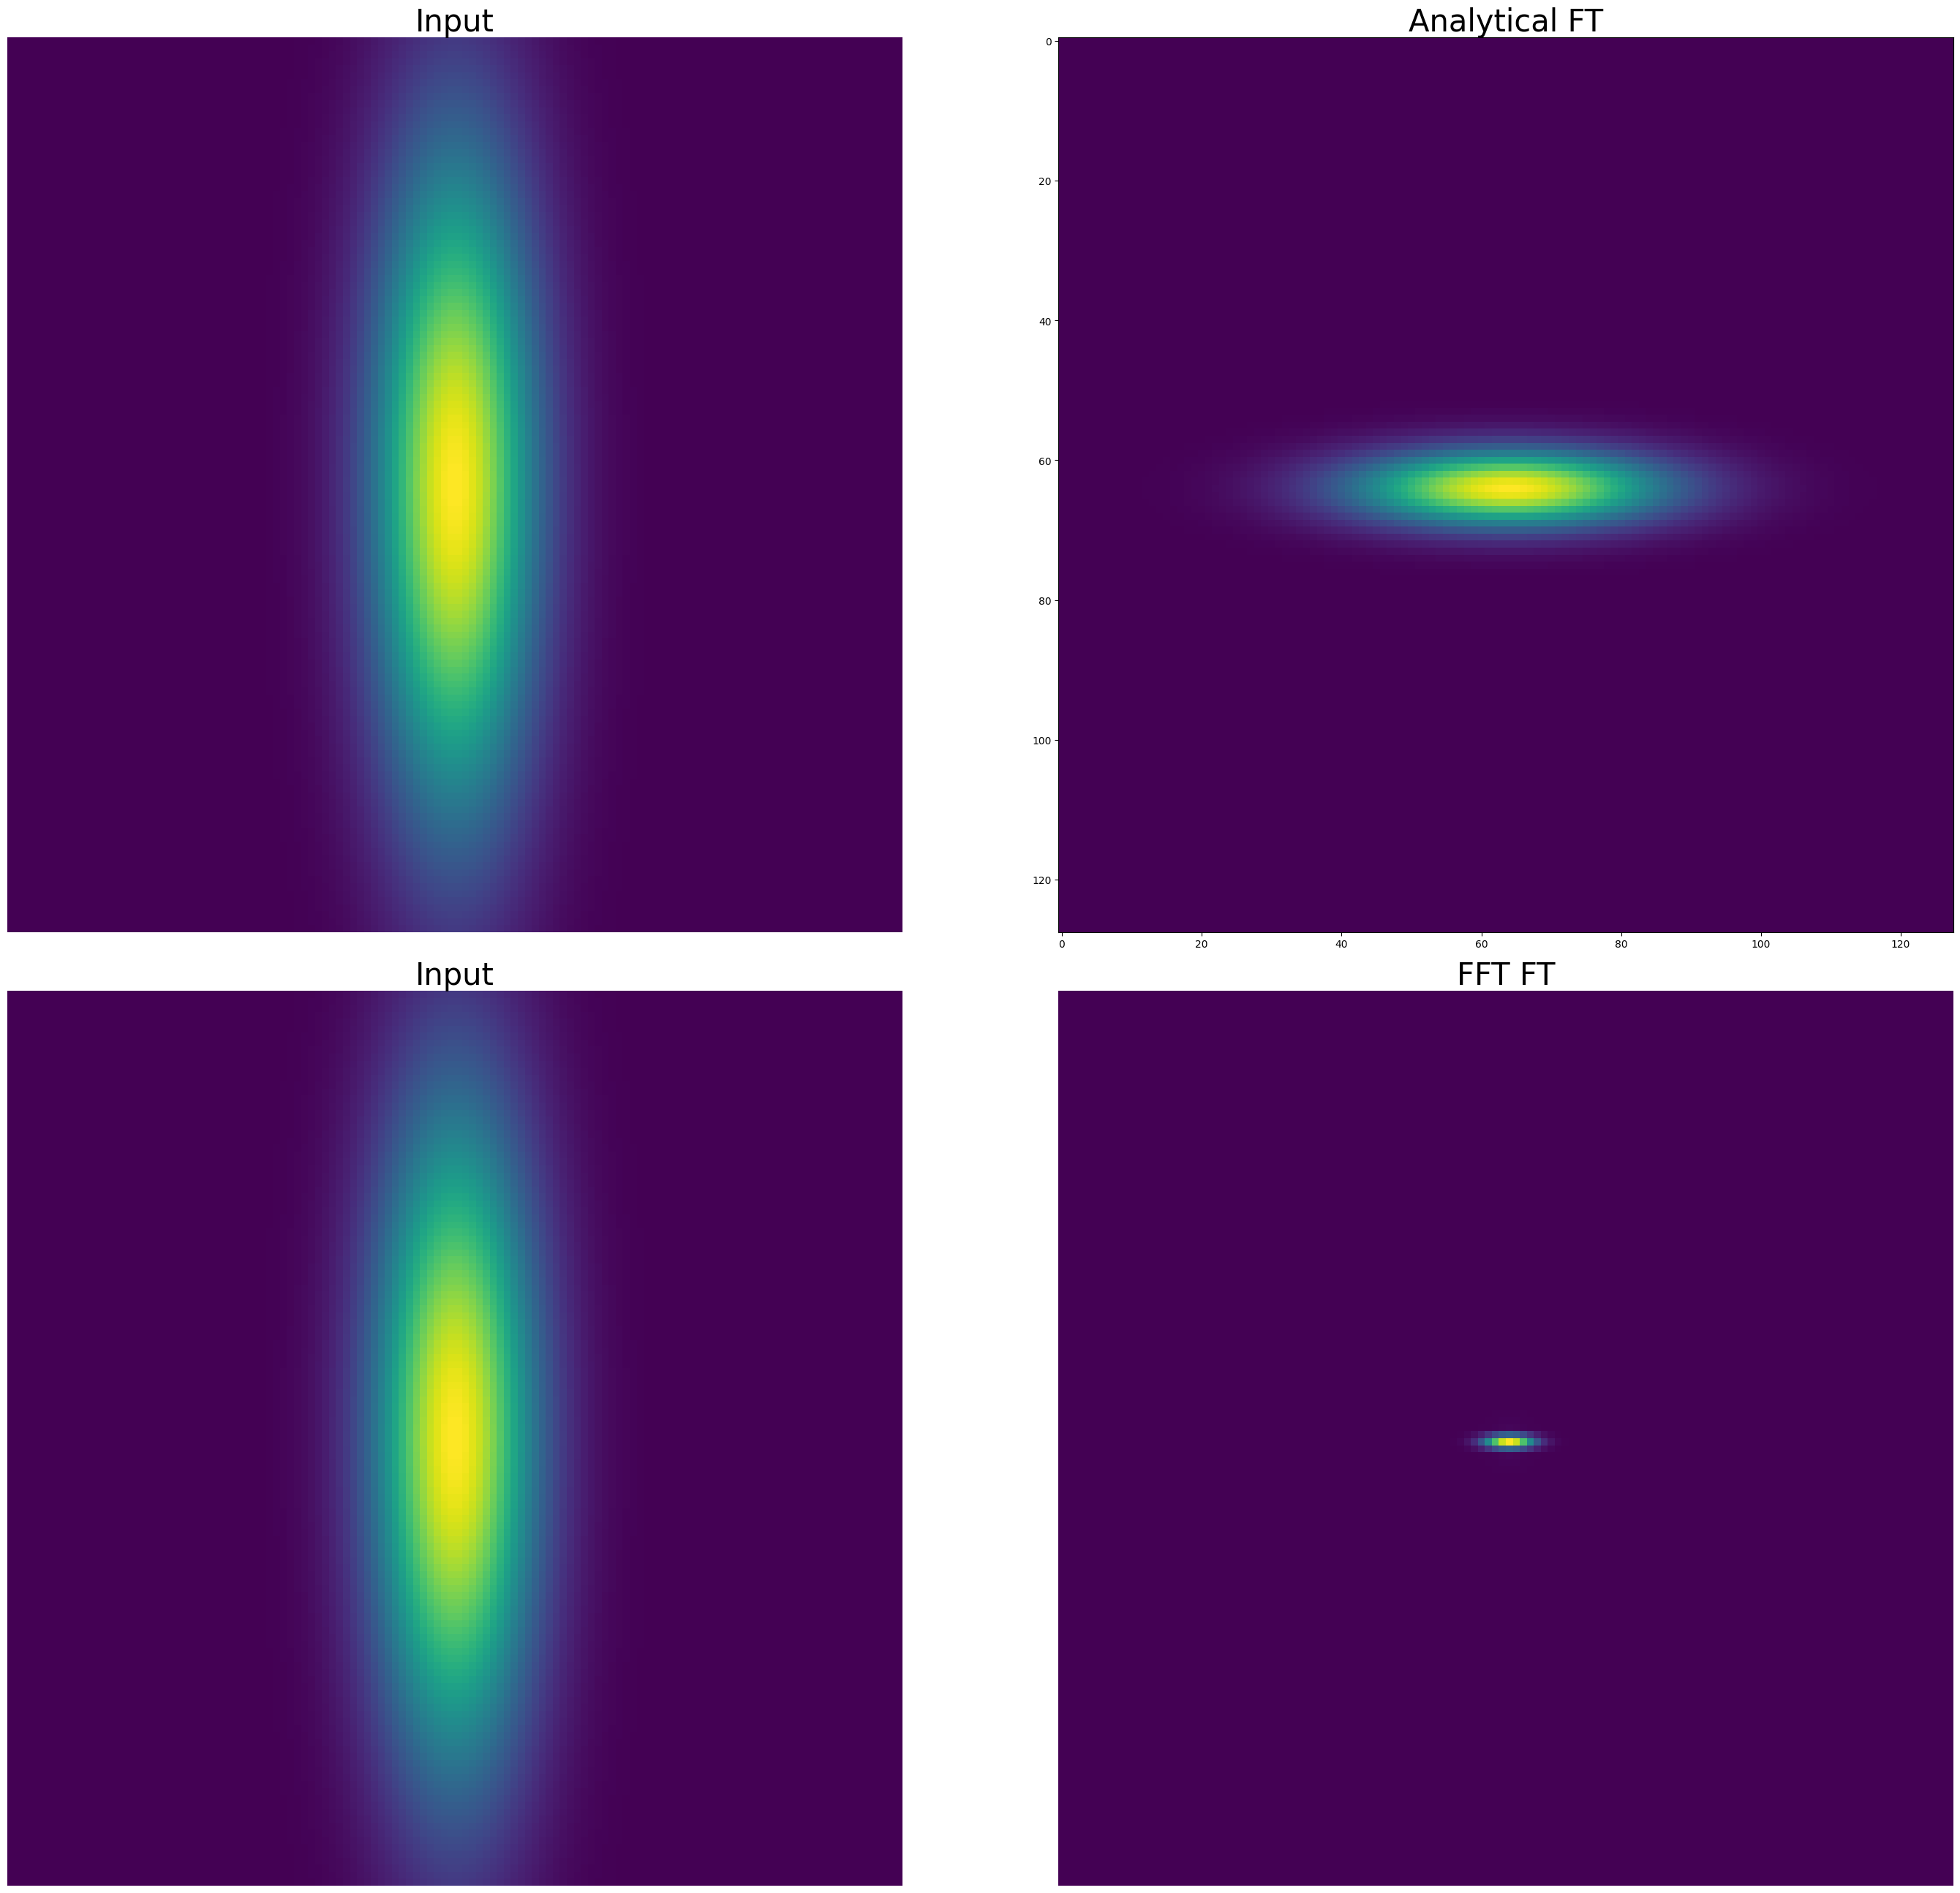

In [4]:
sig_x = 1.3
sig_y = 5.3

gauss = gauss_2d(x0=0,
                y0=0,
                sigma_x=sig_x,
                sigma_y=sig_y,
                rho=0)

FFT = fft.fftshift(fft.fft2(gauss))

in_gauss, analyFT = analytical_nonrot_gauss(sigma_x=sig_x,
                                  sigma_y=sig_y)

# print("Is the analytical solution to the FT the same as the FFT solution?",
#       np.allclose((1/(128**2))*np.abs(analyFT),np.abs(DFT)))

fig, axes = plt.subplots(2, 2, figsize=(30,26))
axes[0,0].imshow(gauss)
axes[0,0].axis('off')
axes[0,0].set_title('Input', fontsize=30)
axes[0,1].imshow((1/128)**2 * (analyFT.real))
axes[0,1].axis('on')
axes[0,1].set_title('Analytical FT', fontsize=30)
axes[1,0].imshow(gauss)
axes[1,0].axis('off')
axes[1,0].set_title('Input', fontsize=30)
axes[1,1].imshow(np.abs(FFT))
axes[1,1].axis('off')
axes[1,1].set_title('FFT FT', fontsize=30)


plt.tight_layout()
plt.show()

### 1.1.2 FT of Rotated Gaussian

**FT of small round gaussian $\rightarrow$ large FT Gaussian**

In [5]:
def analytical_rotgauss_FT(sigma_x=1.0,
                            sigma_y=1.0,
                            rho=0.5,
                            A=1,
                            N=128):

    
    
    # Get the gaussian and FT of the gaussian
    gauss, DFT = DFT_calc(sigma_x=sigma_x, sigma_y=sigma_y, rho=rho)

    # Get the frequency coords of the FT ie. x/y -> u/v
    FreqCompRows = np.fft.fftfreq(DFT.shape[0],d=1) #u
    u = FreqCompRows
    FreqCompCols = np.fft.fftfreq(DFT.shape[1],d=1) #b
    v = FreqCompCols
    
    # Create frequency grid
    Ug, Vg = np.meshgrid(u, v)
    
    exp_u = -2*np.pi**2 * sigma_x**2 * Ug**2
    exp_v = -2*np.pi**2 * sigma_y**2 * Vg**2
    exp_uv = -4*np.pi**2 * sigma_x * sigma_y * rho * Ug * Vg
    
    rot_FT = np.exp(exp_u + exp_v + exp_uv)
    rot_FT = fft.fftshift(rot_FT)
    
    return gauss, rot_FT

**Testing to see if my analytical function of the rotated 2d elliptical gaussian FT is the same as what I would get from doing an FFT**

**New calculated equations**

$$\begin{align*} \text{Input Equation:} \hspace{-3.5in}\\
                               f(x,y) &= \frac{1}{2\pi \sigma_x \sigma_y \sqrt{1-\rho^2}}\text{exp}\Big(-\frac{x^2}{2\sigma_x^2(1-\rho^2)}
                                                        -\frac{y^2}{2\sigma_y^2(1-\rho^2)}
                                                        -\frac{xy\rho}{\sigma_x\sigma_y(1-\rho^2)}\Big) \end{align*}$$

$$\begin{align*} \text{Analytical FT Equation:} \hspace{-2.5in}\\
\hat{f}(u,v) &= \text{exp}\Big(-2\pi^2 \big[\sigma_x^2 u^2 + \sigma_y^2 v^2 + 2\sigma_x \sigma_y \rho uv\big]\Big) \end{align*}$$

Is the analytical solution to the FT the same as the FFT solution? False


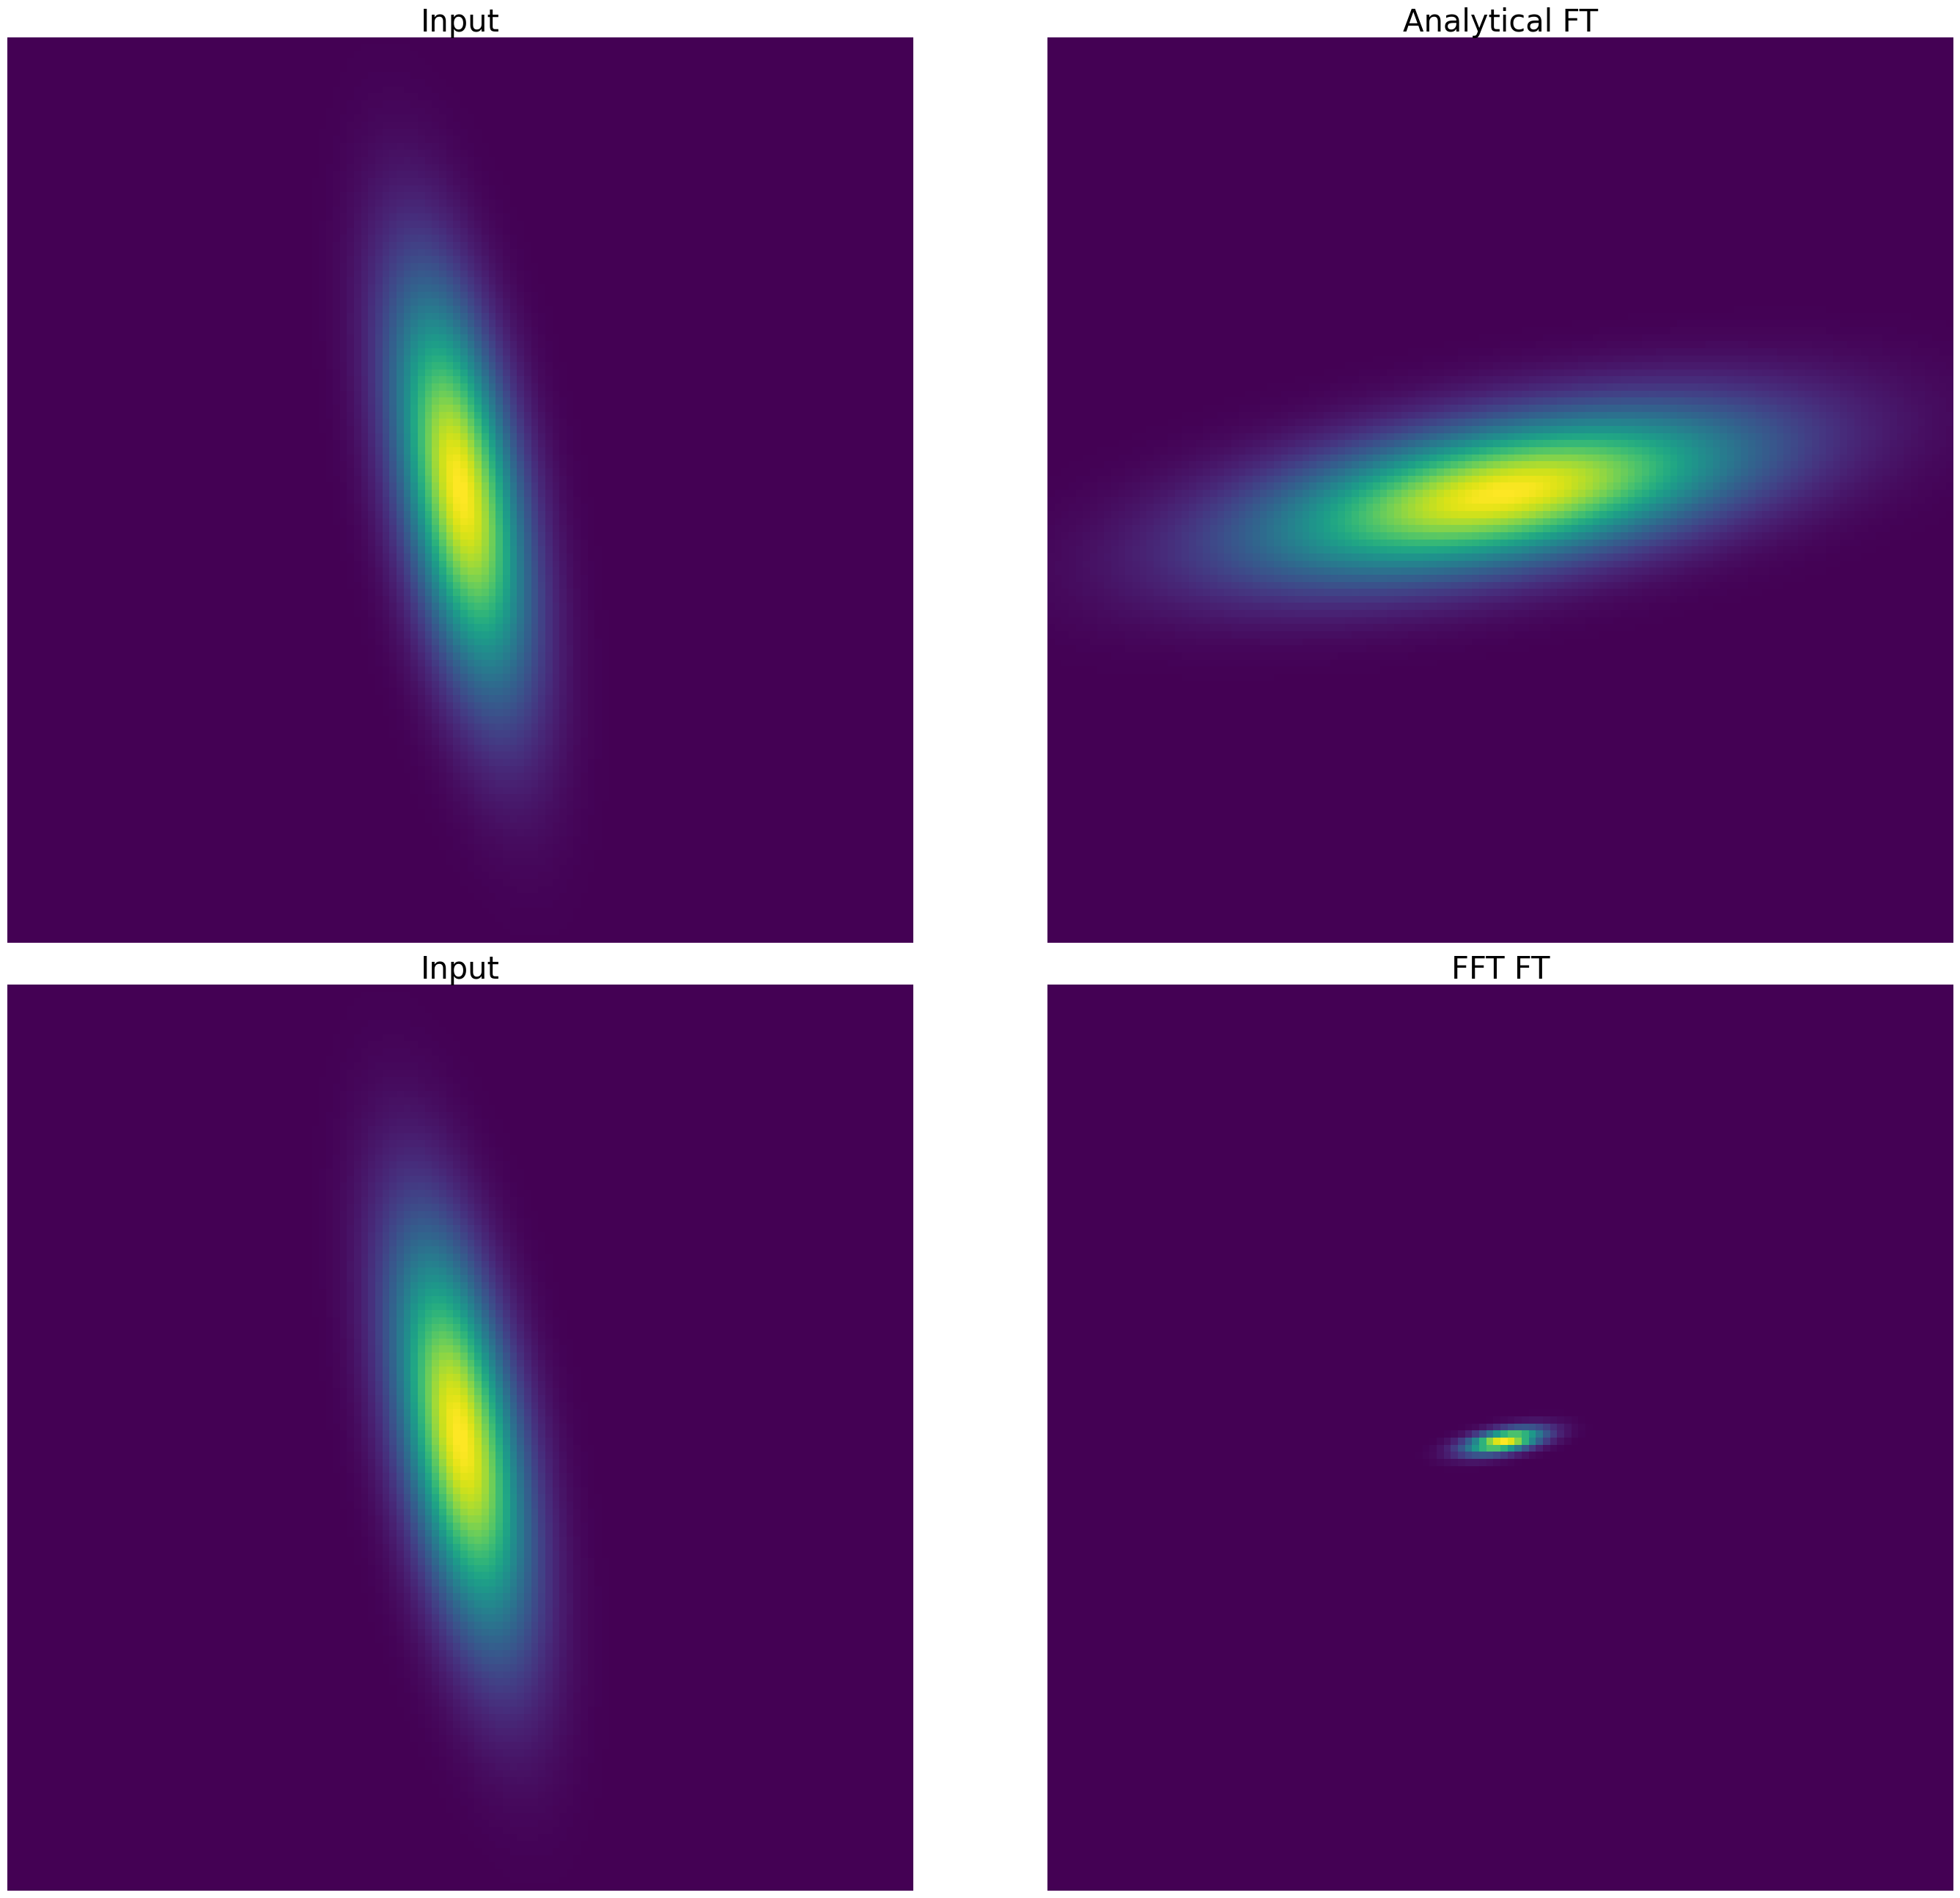

In [6]:
sig_x = 1.0
sig_y = 3.0
rho=0.5
N = 128

gauss, DFT = DFT_calc(sigma_x=sig_x, sigma_y=sig_y, rho=rho)


in_gauss, analyFT = analytical_rotgauss_FT(sigma_x=sig_x,
                                  sigma_y=sig_y, rho=rho)

# analyFT = np.abs(analyFT/N**2)

print("Is the analytical solution to the FT the same as the FFT solution?", np.allclose(np.abs(analyFT),
                                                                                        np.abs(DFT)))


vmax, vmin = np.percentile(analyFT, (99,1))
# vmin = -vmax

fig, axes = plt.subplots(2, 2, figsize=(30,26))
axes[0,0].imshow(in_gauss)
axes[0,0].axis('off')
axes[0,0].set_title('Input', fontsize=30)
axes[0,1].imshow(np.abs(analyFT))
axes[0,1].axis('off')
axes[0,1].set_title('Analytical FT', fontsize=30)
axes[1,0].imshow(gauss)
axes[1,0].axis('off')
axes[1,0].set_title('Input', fontsize=30)
axes[1,1].imshow(np.abs(DFT/N**2))
axes[1,1].axis('off')
axes[1,1].set_title('FFT FT', fontsize=30)


plt.tight_layout()
plt.show()

## 1.3 Round/Elliptical Sheared Gaussian

### 1.3.1 Round Sheared Gaussian

In [7]:
def sheared_gauss(x0=0,
                  y0=0,
                  sigma_x=1.0,
                  sigma_y=1.0,
                  rho=0.0,
                  g1=0.1,
                  g2=0.1,
                  kappa=2,
                  A=1,
                  N=128):
    '''
    General function to calculate 2D gaussian. Allows for circular, elliptical,
    rotated, and off-centered gaussians. The values of the Gaussian function are
    calculated by the given positions in the x and y meshgrid.
    
    Args:
    -----
        x: np.ndarray
            Matrix of the x-coordinates that make up the x-coordinates of each point in 
            the meshgrid. 
            NOTE: In a meshgrid a single point has 2 coordinates ie. (x,y)
        y: np.ndarray
            Matrix of the y-coordinates that make up the y-coordinates of each point in 
            the meshgrid.
            NOTE: In a meshgrid a single point has 2 coordinates ie. (x,y)
        x0: int 
            The x-coordinate of the center of the Gaussian.
            Defaults to 0.
        y0: int
            The y-coordinate of the center of the Gaussian.
        rho: float
            The correlation coefficient. Measure of direction and magnitude of stretch/
            rotation. Values must be between [-1,1].
            Defaults to 0.5.
        g1: float
            The first reduced shear component that describes the elongation along 
            the coordinate axes.
            Defaults is 0.1. Values between [-1,1]
        g2: float
            The second reduced shear component that describes the elongation at 45°
            from the coordinate axes.
            Defaults is 0.1. Values between [-1,1]
        kappa: float
            Convergence of the shear. Describes the change in size and brightness
            of the sheared galaxy.
            Defaults to 2. Should be positive?
        sigma_x: float
            The width of the gaussian in the x-direction.
            Defaults to 1.0
        sigma_y: float
            The width of the gaussian in the y-direction.
            Defaults to 1.0
        A: int
            The amplitude or "height" of the Gaussian.
        N: int
            Number of samples to create.
            E.g. if N=128 we'll create a meshgrid that is (128,128) and thus return
            an (128,128) Gaussian image.
            Defaults to 128.
            
            
    Returns:
    --------
        gauss: np.ndarray
            The array containing the gaussian function evaluated at each point
            in the meshgrid. I.e. returns the image of the Gaussian.
    '''
    x = np.linspace(-10,10,N)
    y = np.linspace(-10,10,N)
    Xg, Yg = np.meshgrid(x, y)

   # Create Gaussian
    non_sheared_gauss = gauss_2d(x0=x0,
                    y0=y0,
                    sigma_x=sigma_x,
                    sigma_y=sigma_y,
                    rho=rho,
                    A=A)
    
    prefactor = -(1-kappa)**2/2
    exp_x = (Xg**2 * (1-g1)**2 + Yg**2*g2**2 - 2*Xg*Yg*g2*(1-g1)) / (sigma_x**2 * (1-rho**2))
    exp_y = (Xg**2*g2**2 + Yg**2*(1+g1)**2 - 2*Xg*Yg*g2*(1+g1)) / (sigma_y**2*(1-rho**2))
    exp_xy = (2*rho*g2*(1-g1)*Xg**2 + 2*rho*g2*(1+g1)*Yg**2 
              - 2*Xg*Yg*rho*g2**2 - 2*Xg*Yg*rho*(1+g1)*(1-g1)) / (sigma_x*sigma_y*(1-rho**2))
    exp = prefactor * (exp_x + exp_y + exp_xy)
    
    sheared_gauss = A * np.exp(exp)
    return non_sheared_gauss, sheared_gauss

Using Mandelbaum's notation for reduced shear components, shear and magnification are parameterized as: 

$$\begin{bmatrix} x_u \cr y_u\end{bmatrix} = (1-\kappa)\begin{bmatrix} 1-g_1 & -g_2 \\ -g_2 & 1+g_1 
\end{bmatrix} \begin{bmatrix} x_l \cr y_l\end{bmatrix}$$

where:
- $(x_u, y_u$) are the unlensed coordinates
- $(x_l, y_l)$ are the lensed coordinates
- $g_i = \gamma_i/(1-\kappa)$ is the form of the reduced shear components

But for our purposes, we want to know the lensed coordinates due to my code not implementing the effects of the DM, thus we'd be looking for something like:

 $$\begin{bmatrix} x_l \cr y_l\end{bmatrix} = (1-\kappa)^{-1}\begin{bmatrix} 1-g_1 & -g_2 \\ -g_2 & 1+g_1 
\end{bmatrix}^{-1} \begin{bmatrix} x_u \cr y_u\end{bmatrix}$$

But we need to know how to parameterize the covariance matrix $C$ in the parameterized 2D gaussian equation ie: $$\begin{align*} f(x,y) &= A \hspace{1mm} \text{exp}(-\frac{1}{2} \vec{r}^{T} C^{-1} \vec{r}) \\ \xi &\equiv \vec{r}^{T} C^{-1} \vec{r} \\ \vec{r} &= \begin{bmatrix} x_u \cr y_u\end{bmatrix} \end{align*}$$

For the simplest case of a round 2D gaussian I parameterized $C^{' -1}$ as: $$\begin{align*} C^{' -1} &= (1-\kappa)^{-1}\begin{bmatrix} 1-g_1 & -g_2 \\ -g_2 & 1+g_1 
\end{bmatrix}^{-1} \begin{bmatrix} \sigma_x^2 & 0 \\ 0 & \sigma_y^2 
\end{bmatrix}^{-1} \\ \end{align*}$$

Plugging this into $\xi$ I found: $$\begin{align*} \xi &= \vec{r}^{T} C^{'-1} \vec{r} \\ &= \vec{r}^{T} (1-\kappa)^{-1}\begin{bmatrix} 1-g_1 & -g_2 \\ -g_2 & 1+g_1 
\end{bmatrix}^{-1} \begin{bmatrix} \sigma_x^2 & 0 \\ 0 & \sigma_y^2 
\end{bmatrix}^{-1} \vec{r} \\
&= \frac{x^2(1+g_1) + xy(g_2)}{\sigma_x^2(1-\kappa)(1-g_1^2-g_2^2)} + \frac{xy(g_2)+y^2(1-g_1)}{\sigma_y^2(1-\kappa)(1-g_1^2 - g_2^2)}\end{align*}$$


Thus, the sheared galaxy function is: $$f(x,y) = A \text{exp} \Big[-\frac{1}{2(1-\kappa)(1-g_1^2-g_2^2)}\Big(\frac{x^2(1+g_1) + xy(g_2)}{\sigma_x^2} + \frac{xy(g_2)+y^2(1-g_1)}{\sigma_y^2} \Big) \Big]$$


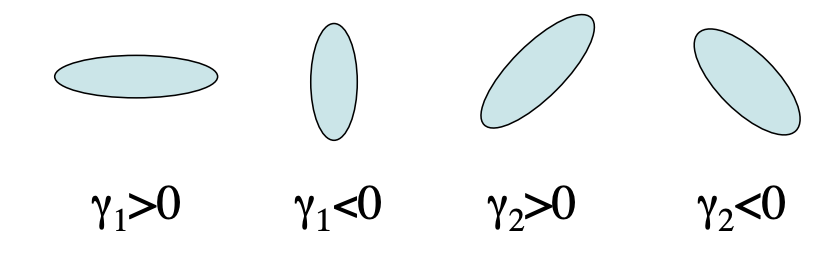

**Kappa only**

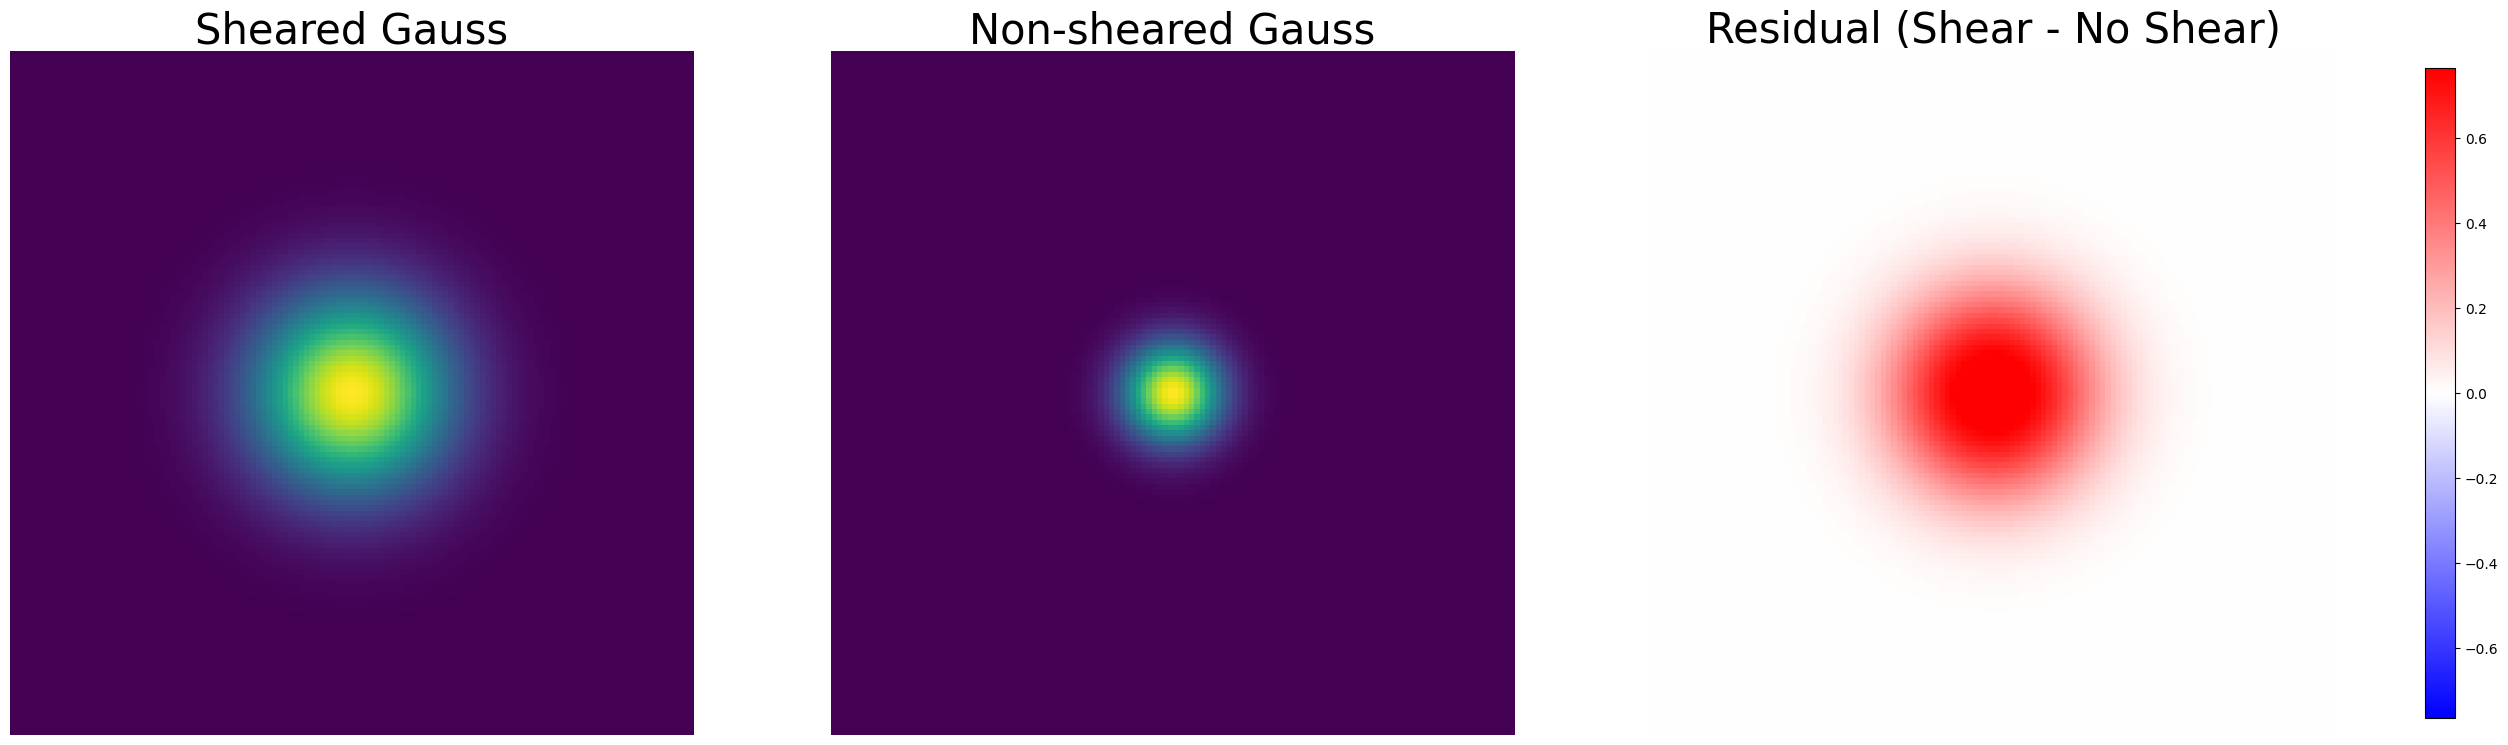

In [8]:
gauss, sheared = sheared_gauss(sigma_x=1.0,
                      sigma_y=1.0,
                      rho=0.0,
                      g1=-0.0, # Stretching along coord axis
                      g2=0.0, # Stretching at 45 deg from coord axis
                      kappa=0.5)
# Get residual image to see the difference when changing params
residual = sheared - gauss
vmax = np.percentile((residual), (99))
vmin = -vmax

fig, axes = plt.subplots(1, 3, figsize=(30,26))
axes[0].imshow(sheared)
axes[0].axis('off')
axes[0].set_title('Sheared Gauss', fontsize=30)
axes[1].imshow(gauss)
axes[1].axis('off')
axes[1].set_title('Non-sheared Gauss', fontsize=30)
im = axes[2].imshow(residual, vmax=vmax, vmin=vmin, cmap='bwr')
# im = axes[2].imshow(residual, cmap='bwr')
axes[2].axis('off')
axes[2].set_title('Residual (Shear - No Shear)', fontsize=30)

cax = plt.axes([0.93, 0.37, 0.01, 0.25])
fig.colorbar(im, cax=cax, ax=axes[2])

**`g1` only**

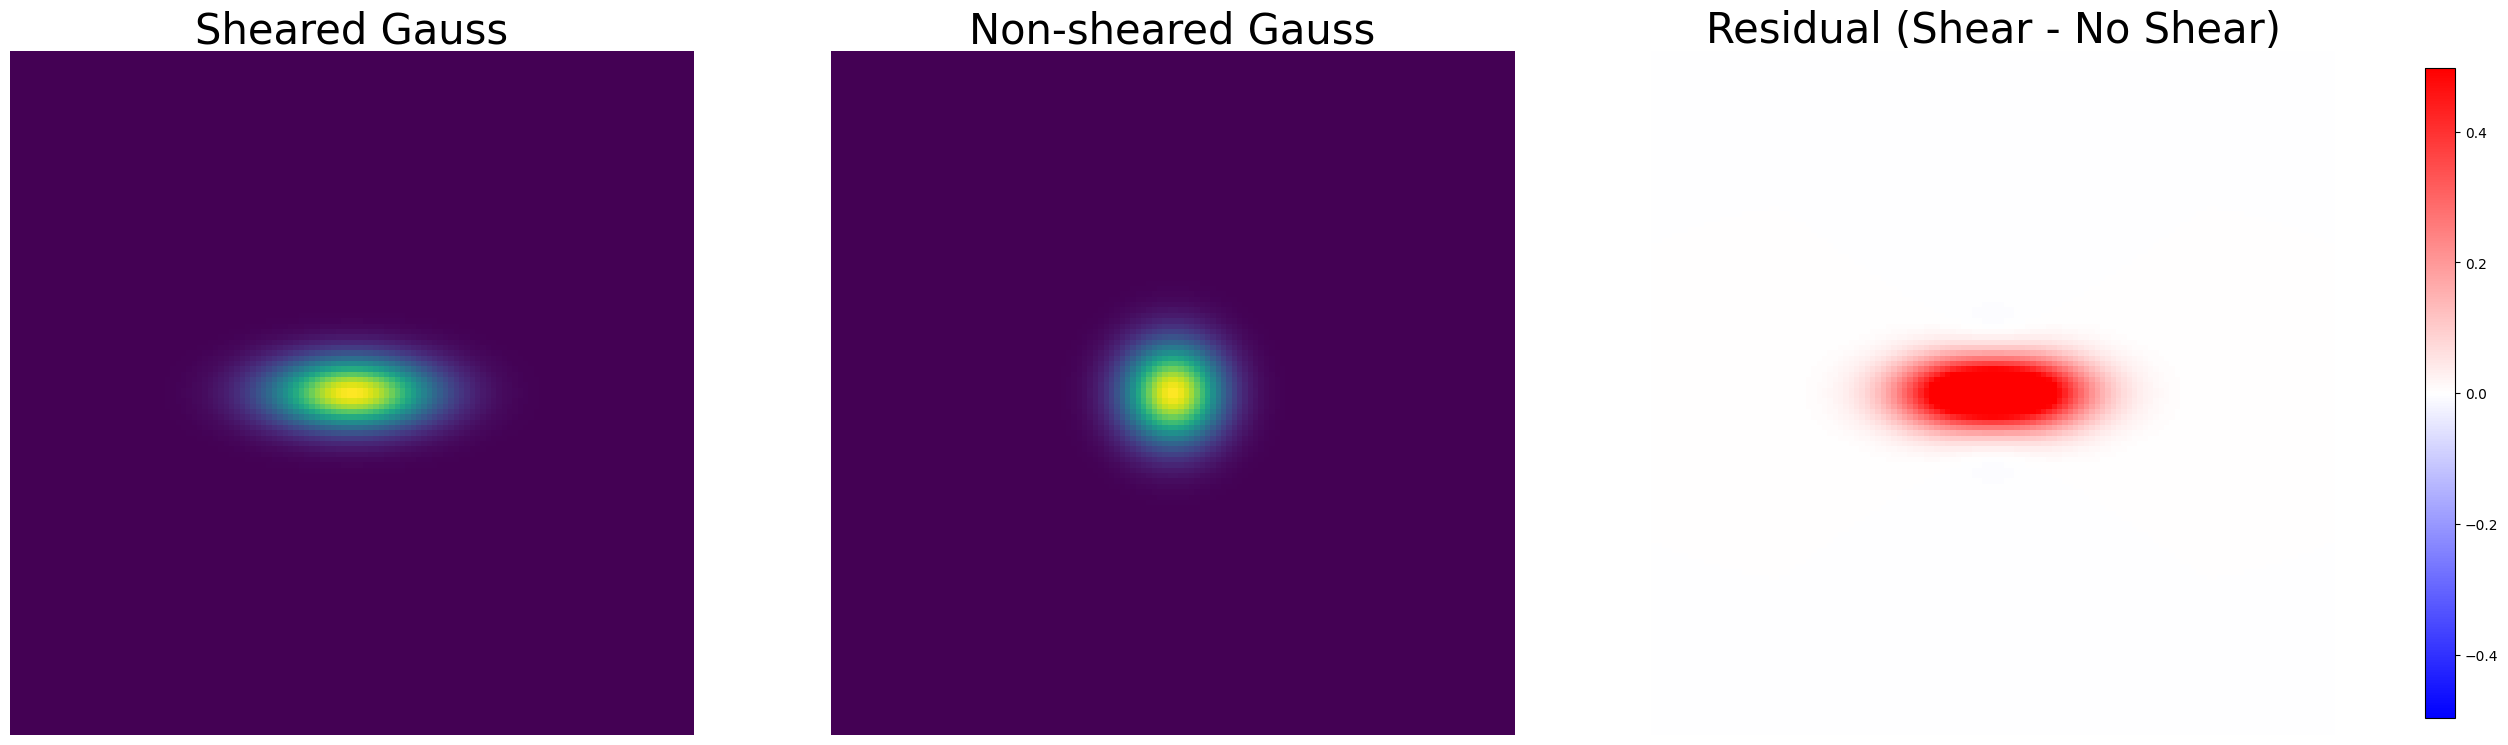

In [9]:
gauss, sheared = sheared_gauss(sigma_x=1.0,
                      sigma_y=1.0,
                      rho=0.0,
                      g1=0.4, # Stretching along coord axis
                      g2=0.0, # Stretching at 45 deg from coord axis
                      kappa=0.0)
# Get residual image to see the difference when changing params
residual = sheared - gauss
vmax = np.percentile((residual), (99))
vmin = -vmax

fig, axes = plt.subplots(1, 3, figsize=(30,26))
axes[0].imshow(sheared)
axes[0].axis('off')
axes[0].set_title('Sheared Gauss', fontsize=30)
axes[1].imshow(gauss)
axes[1].axis('off')
axes[1].set_title('Non-sheared Gauss', fontsize=30)
im = axes[2].imshow(residual, vmax=vmax, vmin=vmin, cmap='bwr')
# im = axes[2].imshow(residual, cmap='bwr')
axes[2].axis('off')
axes[2].set_title('Residual (Shear - No Shear)', fontsize=30)

cax = plt.axes([0.93, 0.37, 0.01, 0.25])
fig.colorbar(im, cax=cax, ax=axes[2])

**`g2` only**

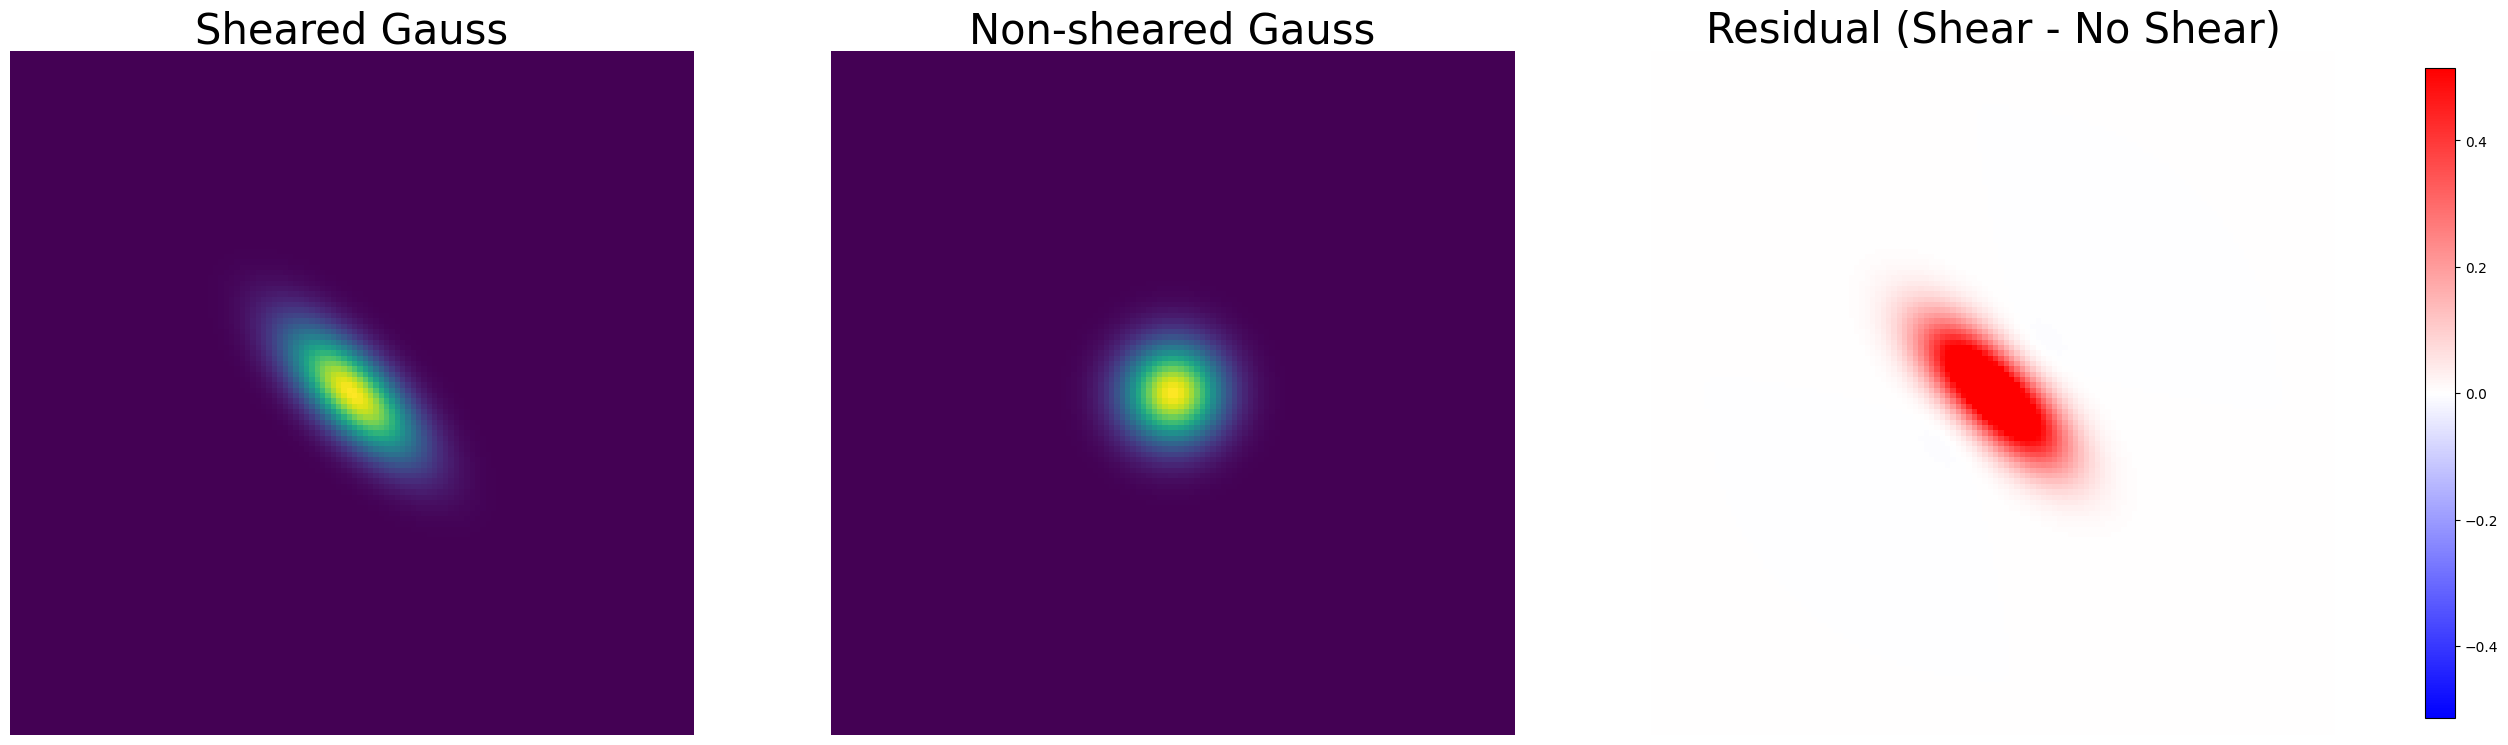

In [10]:
gauss, sheared = sheared_gauss(sigma_x=1.0,
                      sigma_y=1.0,
                      rho=0.0,
                      g1=0.0, # Stretching along coord axis
                      g2=0.4, # Stretching at 45 deg from coord axis
                      kappa=0.0)
# Get residual image to see the difference when changing params
residual = sheared - gauss
vmax = np.percentile((residual), (99))
vmin = -vmax

fig, axes = plt.subplots(1, 3, figsize=(30,26))
axes[0].imshow(sheared)
axes[0].axis('off')
axes[0].set_title('Sheared Gauss', fontsize=30)
axes[1].imshow(gauss)
axes[1].axis('off')
axes[1].set_title('Non-sheared Gauss', fontsize=30)
im = axes[2].imshow(residual, vmax=vmax, vmin=vmin, cmap='bwr')
# im = axes[2].imshow(residual, cmap='bwr')
axes[2].axis('off')
axes[2].set_title('Residual (Shear - No Shear)', fontsize=30)

cax = plt.axes([0.93, 0.37, 0.01, 0.25])
fig.colorbar(im, cax=cax, ax=axes[2])

**`g1 + g2`**

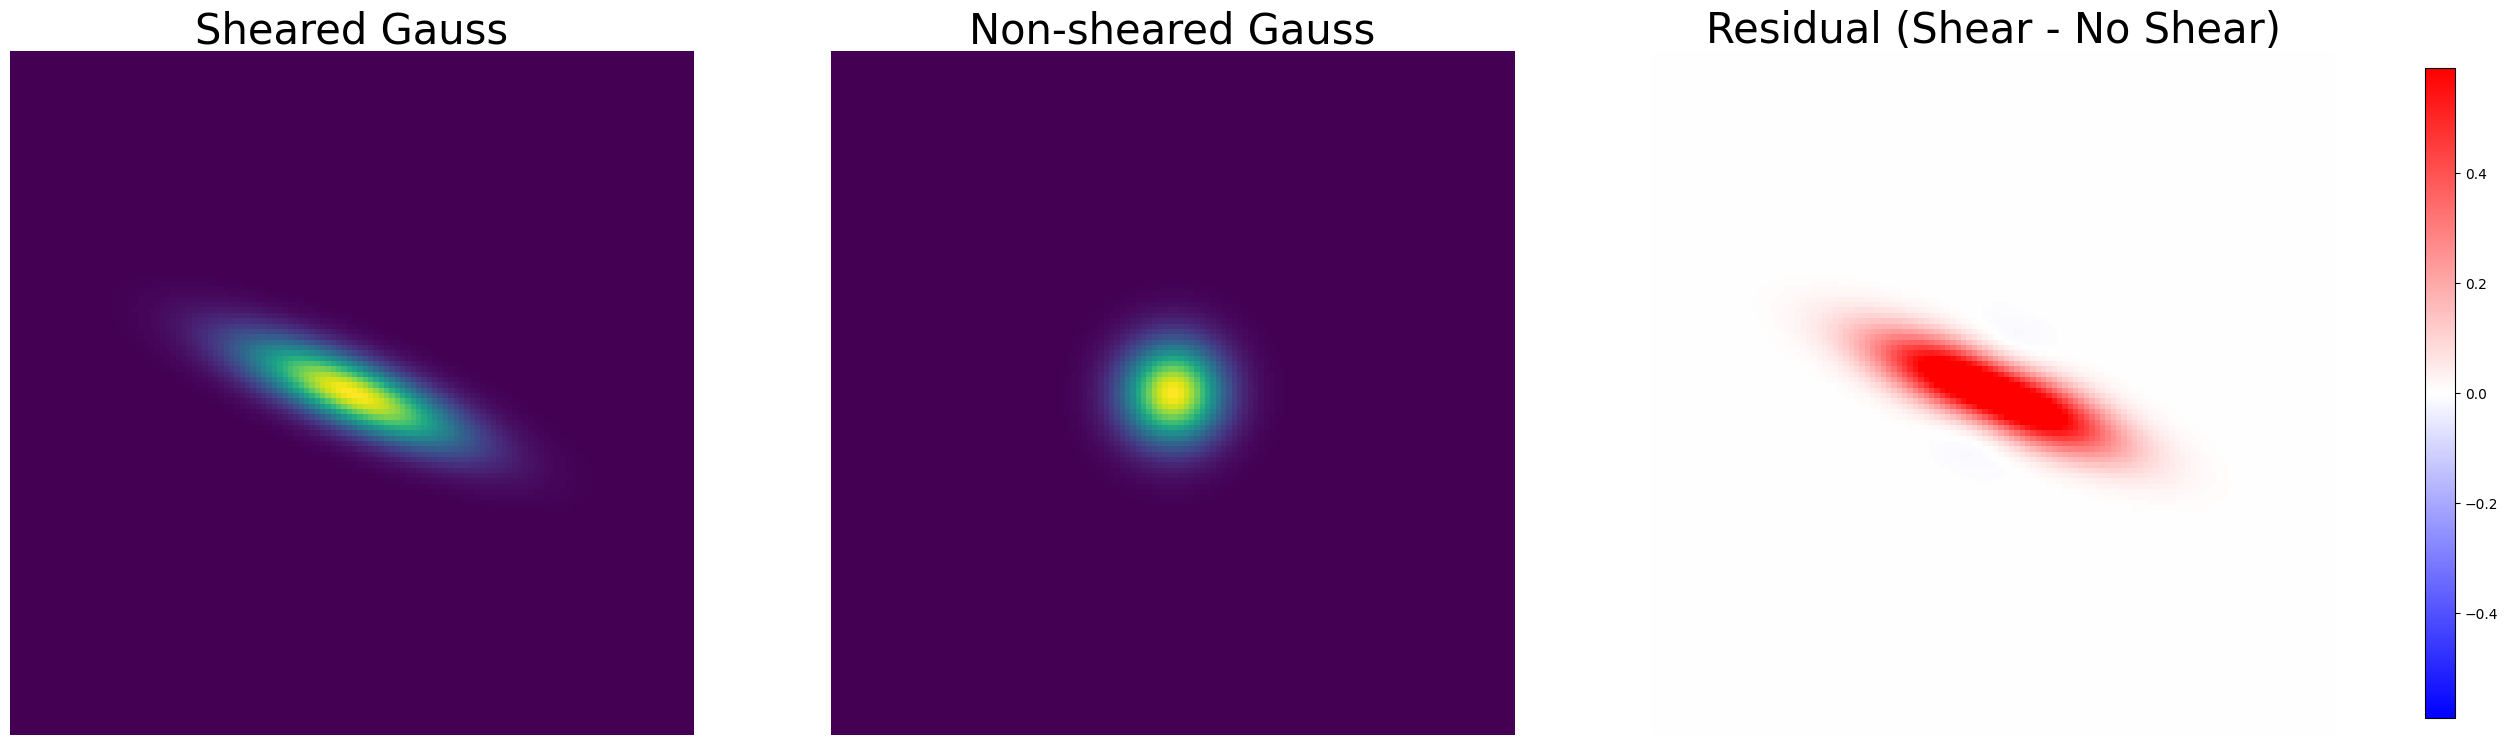

In [11]:
gauss, sheared = sheared_gauss(sigma_x=1.0,
                      sigma_y=1.0,
                      rho=0.0,
                      g1=0.4, # Stretching along coord axis
                      g2=0.4, # Stretching at 45 deg from coord axis
                      kappa=0.0)
# Get residual image to see the difference when changing params
residual = sheared - gauss
vmax = np.percentile((residual), (99))
vmin = -vmax

fig, axes = plt.subplots(1, 3, figsize=(30,26))
axes[0].imshow(sheared)
axes[0].axis('off')
axes[0].set_title('Sheared Gauss', fontsize=30)
axes[1].imshow(gauss)
axes[1].axis('off')
axes[1].set_title('Non-sheared Gauss', fontsize=30)
im = axes[2].imshow(residual, vmax=vmax, vmin=vmin, cmap='bwr')
# im = axes[2].imshow(residual, cmap='bwr')
axes[2].axis('off')
axes[2].set_title('Residual (Shear - No Shear)', fontsize=30)

cax = plt.axes([0.93, 0.37, 0.01, 0.25])
fig.colorbar(im, cax=cax, ax=axes[2])

**`kappa + g1 + g2`**

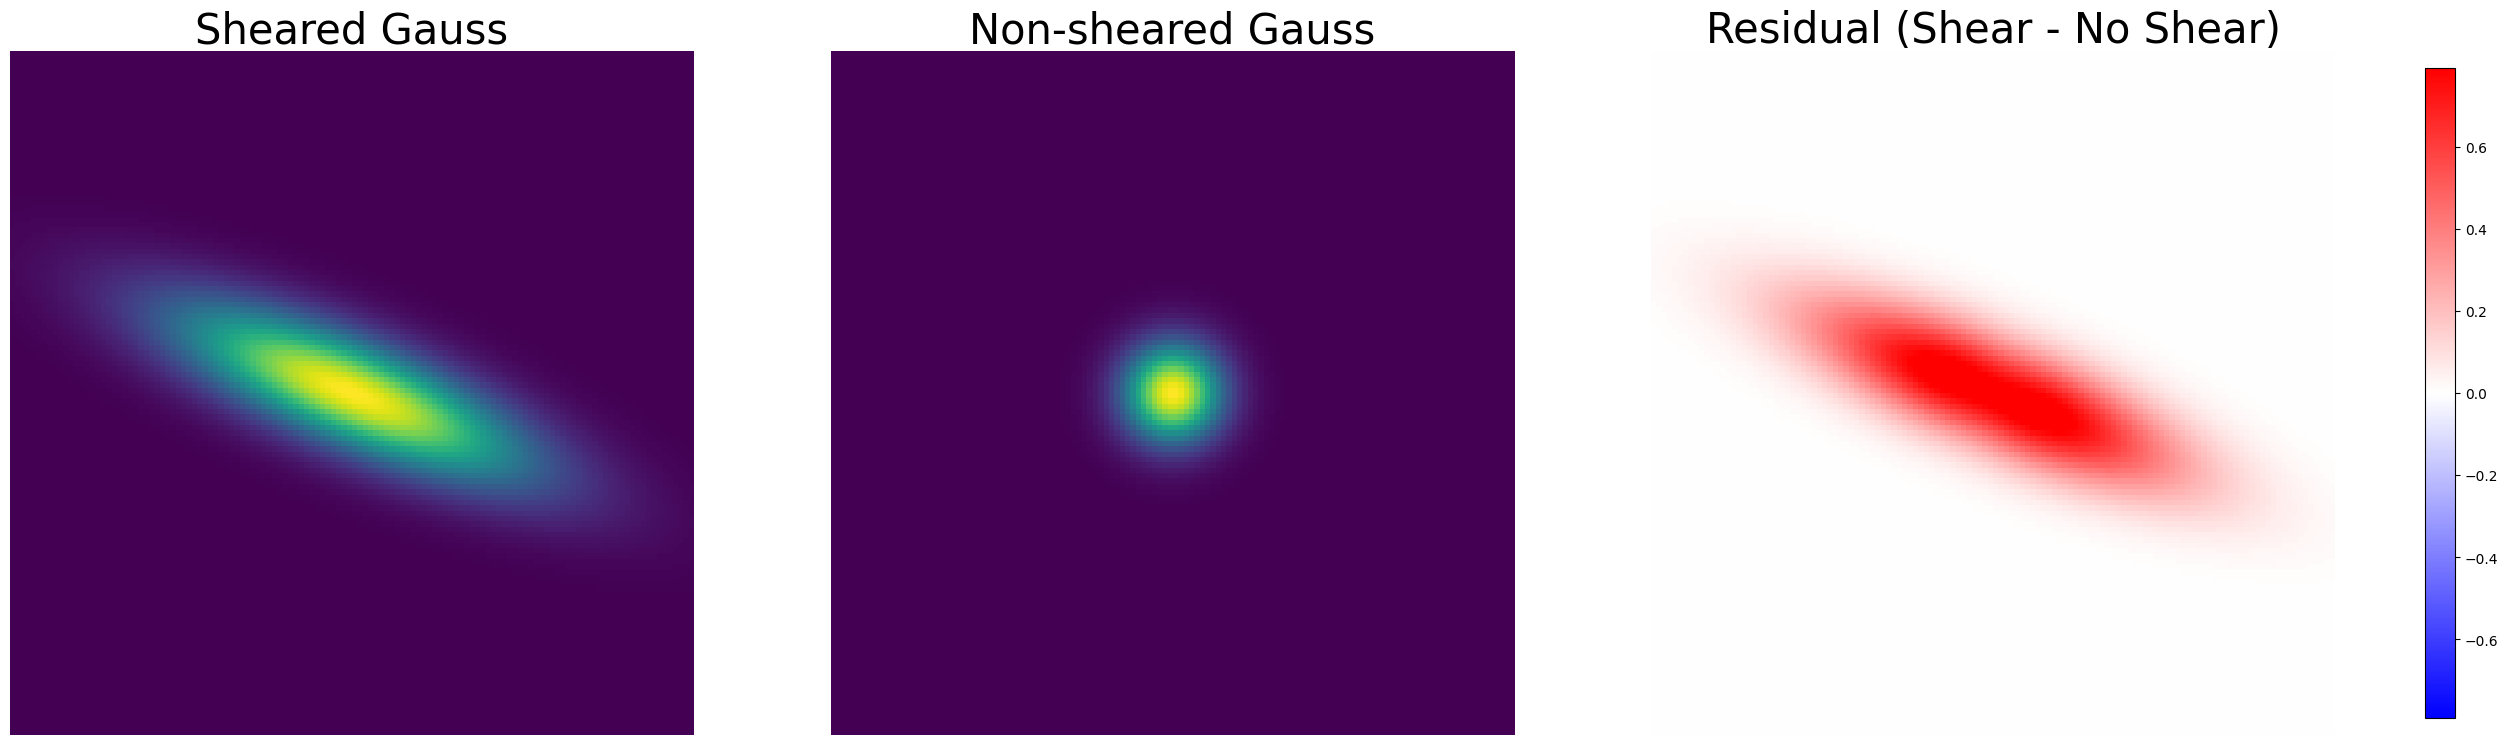

In [12]:
gauss, sheared = sheared_gauss(sigma_x=1.0,
                      sigma_y=1.0,
                      rho=0.0,
                      g1=0.4, # Stretching along coord axis
                      g2=0.4, # Stretching at 45 deg from coord axis
                      kappa=0.4)
# Get residual image to see the difference when changing params
residual = sheared - gauss
vmax = np.percentile((residual), (99))
vmin = -vmax

fig, axes = plt.subplots(1, 3, figsize=(30,26))
axes[0].imshow(sheared)
axes[0].axis('off')
axes[0].set_title('Sheared Gauss', fontsize=30)
axes[1].imshow(gauss)
axes[1].axis('off')
axes[1].set_title('Non-sheared Gauss', fontsize=30)
im = axes[2].imshow(residual, vmax=vmax, vmin=vmin, cmap='bwr')
# im = axes[2].imshow(residual, cmap='bwr')
axes[2].axis('off')
axes[2].set_title('Residual (Shear - No Shear)', fontsize=30)

cax = plt.axes([0.93, 0.37, 0.01, 0.25])
fig.colorbar(im, cax=cax, ax=axes[2])

### 1.3.2 Elliptical Sheared Gaussian

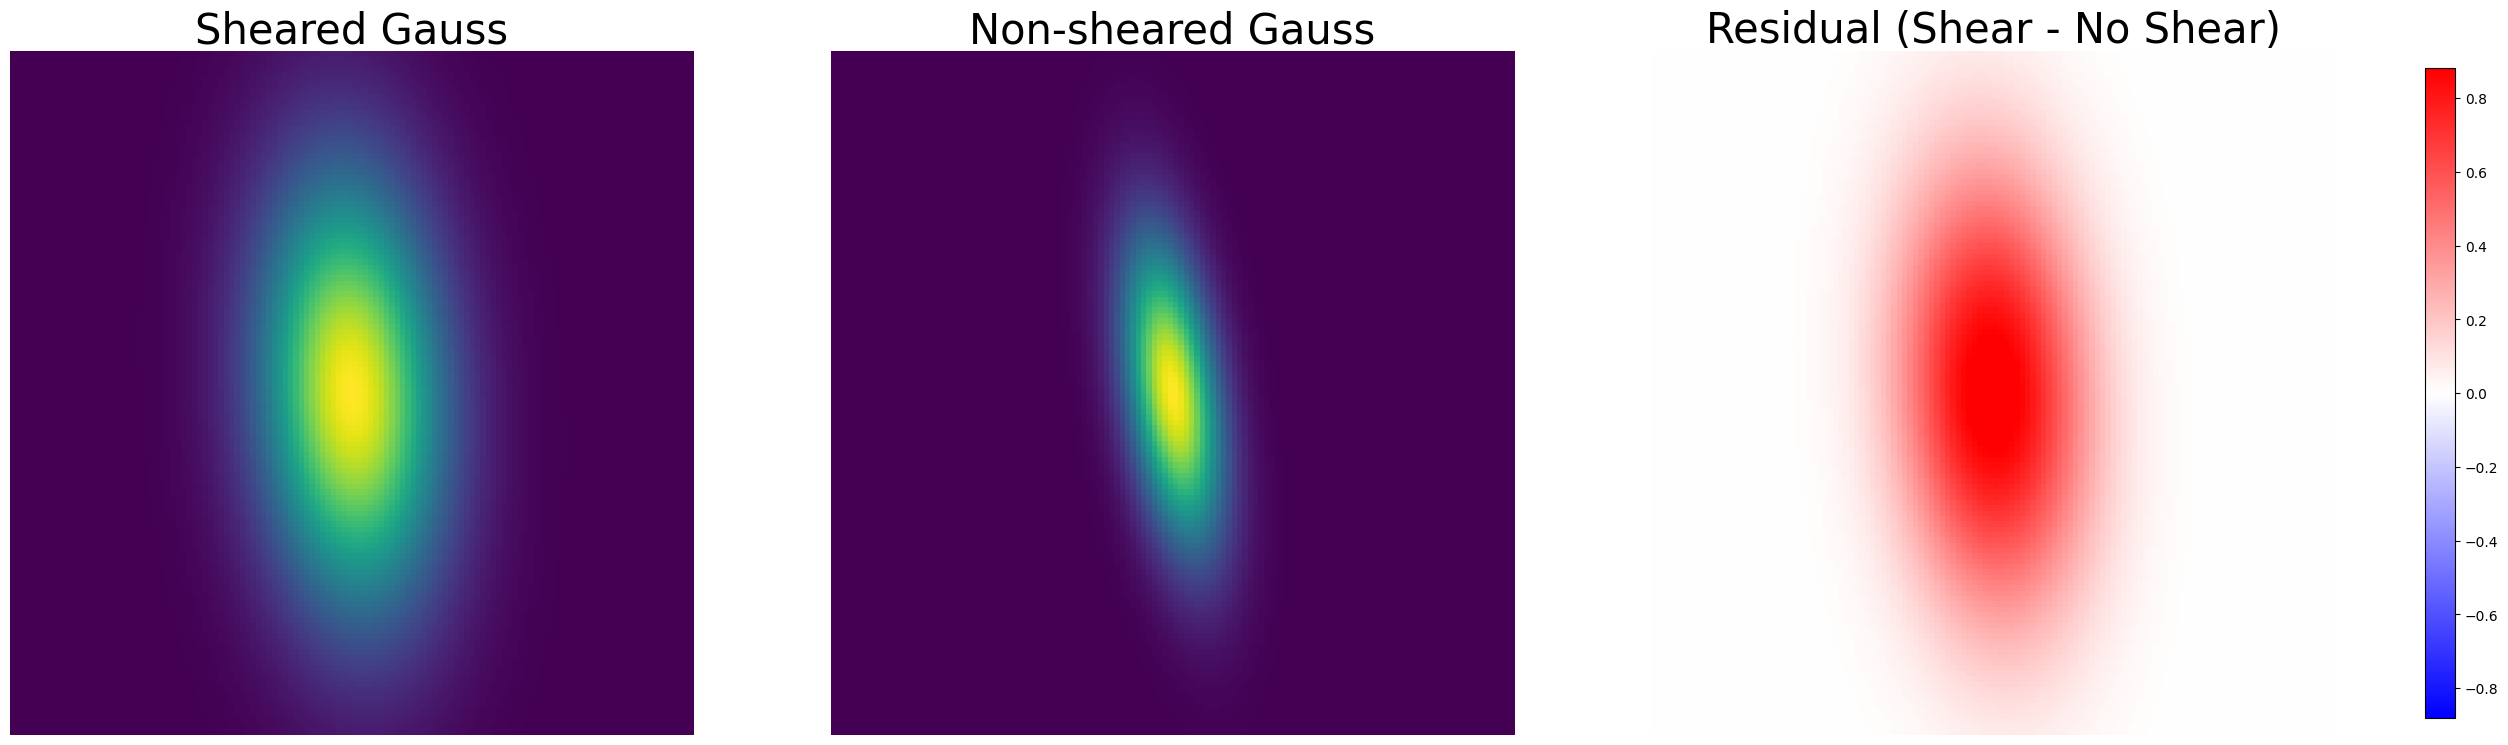

In [13]:
gauss, sheared = sheared_gauss(sigma_x=1.0,
                      sigma_y=3.1,
                      rho=0.4,
                      g1=0.16656789,# Stretching along coord axis
                      g2=-0.1, # Stretching at 45 deg from coord axis
                      kappa=0.4)
# Get residual image to see the difference when changing params
residual = sheared - gauss
vmax = np.percentile((residual), (99))
vmin = -vmax

fig, axes = plt.subplots(1, 3, figsize=(30,26))
axes[0].imshow(sheared)
axes[0].axis('off')
axes[0].set_title('Sheared Gauss', fontsize=30)
axes[1].imshow(gauss)
axes[1].axis('off')
axes[1].set_title('Non-sheared Gauss', fontsize=30)
im = axes[2].imshow(residual, vmax=vmax, vmin=vmin, cmap='bwr')
axes[2].axis('off')
axes[2].set_title('Residual (Shear - No Shear)', fontsize=30)

cax = plt.axes([0.93, 0.37, 0.01, 0.25])
fig.colorbar(im, cax=cax, ax=axes[2])

# 2. Gaussians using `GalSim`: Using [demo2](https://github.com/GalSim-developers/GalSim/blob/releases/2.4/examples/demo2.py) as a guide

Using [galsim](http://galsim-developers.github.io/GalSim/_build/html/tutorials.html#demo-1) for creating the 2 2D gaussian galaxies. Check out the [galsim github](https://github.com/GalSim-developers/GalSim/tree/releases/2.4/examples) for demos of `galsim`.

In [14]:
def create_gauss_gal(gal_flux=1.e5, 
                     gal_sigma=2.0,
                     psf_sigma=1.0, 
                     pixel_scale=0.2,
                     shear_on=False,
                     g1=0.1,
                     g2=0.2,
                     noise_on=False,
                     noise=30.):
    """
    Function that creates a 2D gaussian galaxy using Galsim.
    
    Args:
    -----
        gal_flux: float
            Total counts on the image
            Defaults to 1.e5
        gal_sigma: float
            The value of sigma of the profile. Typically given in arcsec.
            Defaults to 2.0
        psf_sigma: float
            The value of sigma of the PSF profile. Typically given in arcsec.
            Defaults to 1.0
        pixel_scale: float
            The value of how many arcsec/pixel there are. 
            Defaults to 0.2
        noise: float
            Standard deviation of the counts in each pixel.
            Defaults to 30.
        noise_on: Boolean
            Toggles between having a noisy gaussian image or noise-free.
            Defaults to False.
        shear_on: Boolean
            Toggles between shearing the galaxy or not. A shear is an operation
            that transforms a circle into anellipsde with minor-to-major axis
            ratio b/a, with position angle beta, while conserving the area. There
            are multiple ways to define shear, but the version we used is called
            the reduced shear ie:
            
                g1 = |g| cos(2*beta)
                g2 = |g| sin(2*beta)
               |g| = (a-b)/(a+b)
                 g = |g| exp(2i*beta)
            
            Taken as imaginary and real parts, the real part (g1) of the complex
            ellipticity describes the elongation along the coordiante axes, while
            the imaginary part (g2) describes the elongation at 45° from the axes.
        g1: float
            The first reduced shear component that describes the elongation along 
            the coordinate axes. 
            Defaults to 0.1.
        g2: float
            The second reduced shear component that describes the elongation at 45°
            from the coordinate axes.
            Defaults to 0.2
            
    Returns:
        gal: np.ndarray
            The constructed gaussian galaxy image.
            
    """
    # Define the galaxy profile
    gal = galsim.Gaussian(flux=gal_flux, sigma=gal_sigma)
    # Shear the galaxy by some value.
    # There are quite a few ways you can use to specify a shape.
    # q, beta      Axis ratio and position angle: q = b/a, 0 < q < 1
    # e, beta      Ellipticity and position angle: |e| = (1-q^2)/(1+q^2)
    # g, beta      ("Reduced") Shear and position angle: |g| = (1-q)/(1+q)
    # eta, beta    Conformal shear and position angle: eta = ln(1/q)
    # e1,e2        Ellipticity components: e1 = e cos(2 beta), e2 = e sin(2 beta)
    # g1,g2        ("Reduced") shear components: g1 = |g| cos(2 beta), g2 = |g| sin(2 beta)
    # eta1,eta2    Conformal shear components: eta1 = eta cos(2 beta), eta2 = eta sin(2 beta)
    if shear_on == True:  
        gal = gal.shear(g1=g1, g2=g2)
    else:
        pass

    # Define the PSF profile
    psf = galsim.Gaussian(flux=1., sigma=psf_sigma) # PSF flux should always = 1

    # Final profile is the convolution of these
    # Can include any number of things in the list, all of which are convolved
    # together to make the final flux profile.
    final = galsim.Convolve([gal, psf])

    # Draw the image with a particular pixel scale, given in arcsec/pixel.
    # The returned image has a member, added_flux, which is gives the total flux actually added to
    # the image.  One could use this value to check if the image is large enough for some desired
    # accuracy level.  Here, we just ignore it.
    image = final.drawImage(scale=pixel_scale, nx=128, ny=128)

    # Add Gaussian noise to the image with specified sigma
    if noise_on == True:
        image.addNoise(galsim.GaussianNoise(sigma=noise))
        return image.array
    else:
        return image.array
    
def visualize_FT(img):
    
    f, fshift, mag = FFT_IFFT_calc(img=img, FFT=True)
    ifft = FFT_IFFT_calc(img=fshift, FFT=False)
    fig, axes = plt.subplots(1, 3, figsize=(30,26))
    axes[0].imshow(img)
    axes[0].axis('off')
    axes[0].set_title('Input', fontsize=30)
    axes[1].imshow(mag)
    axes[1].axis('off')
    axes[1].set_title('FFT', fontsize=30)
    axes[2].imshow(ifft.real)
    axes[2].axis('off')
    axes[2].set_title('IFFT(FFT(Input))', fontsize=30)
   

    plt.tight_layout()
    plt.show()

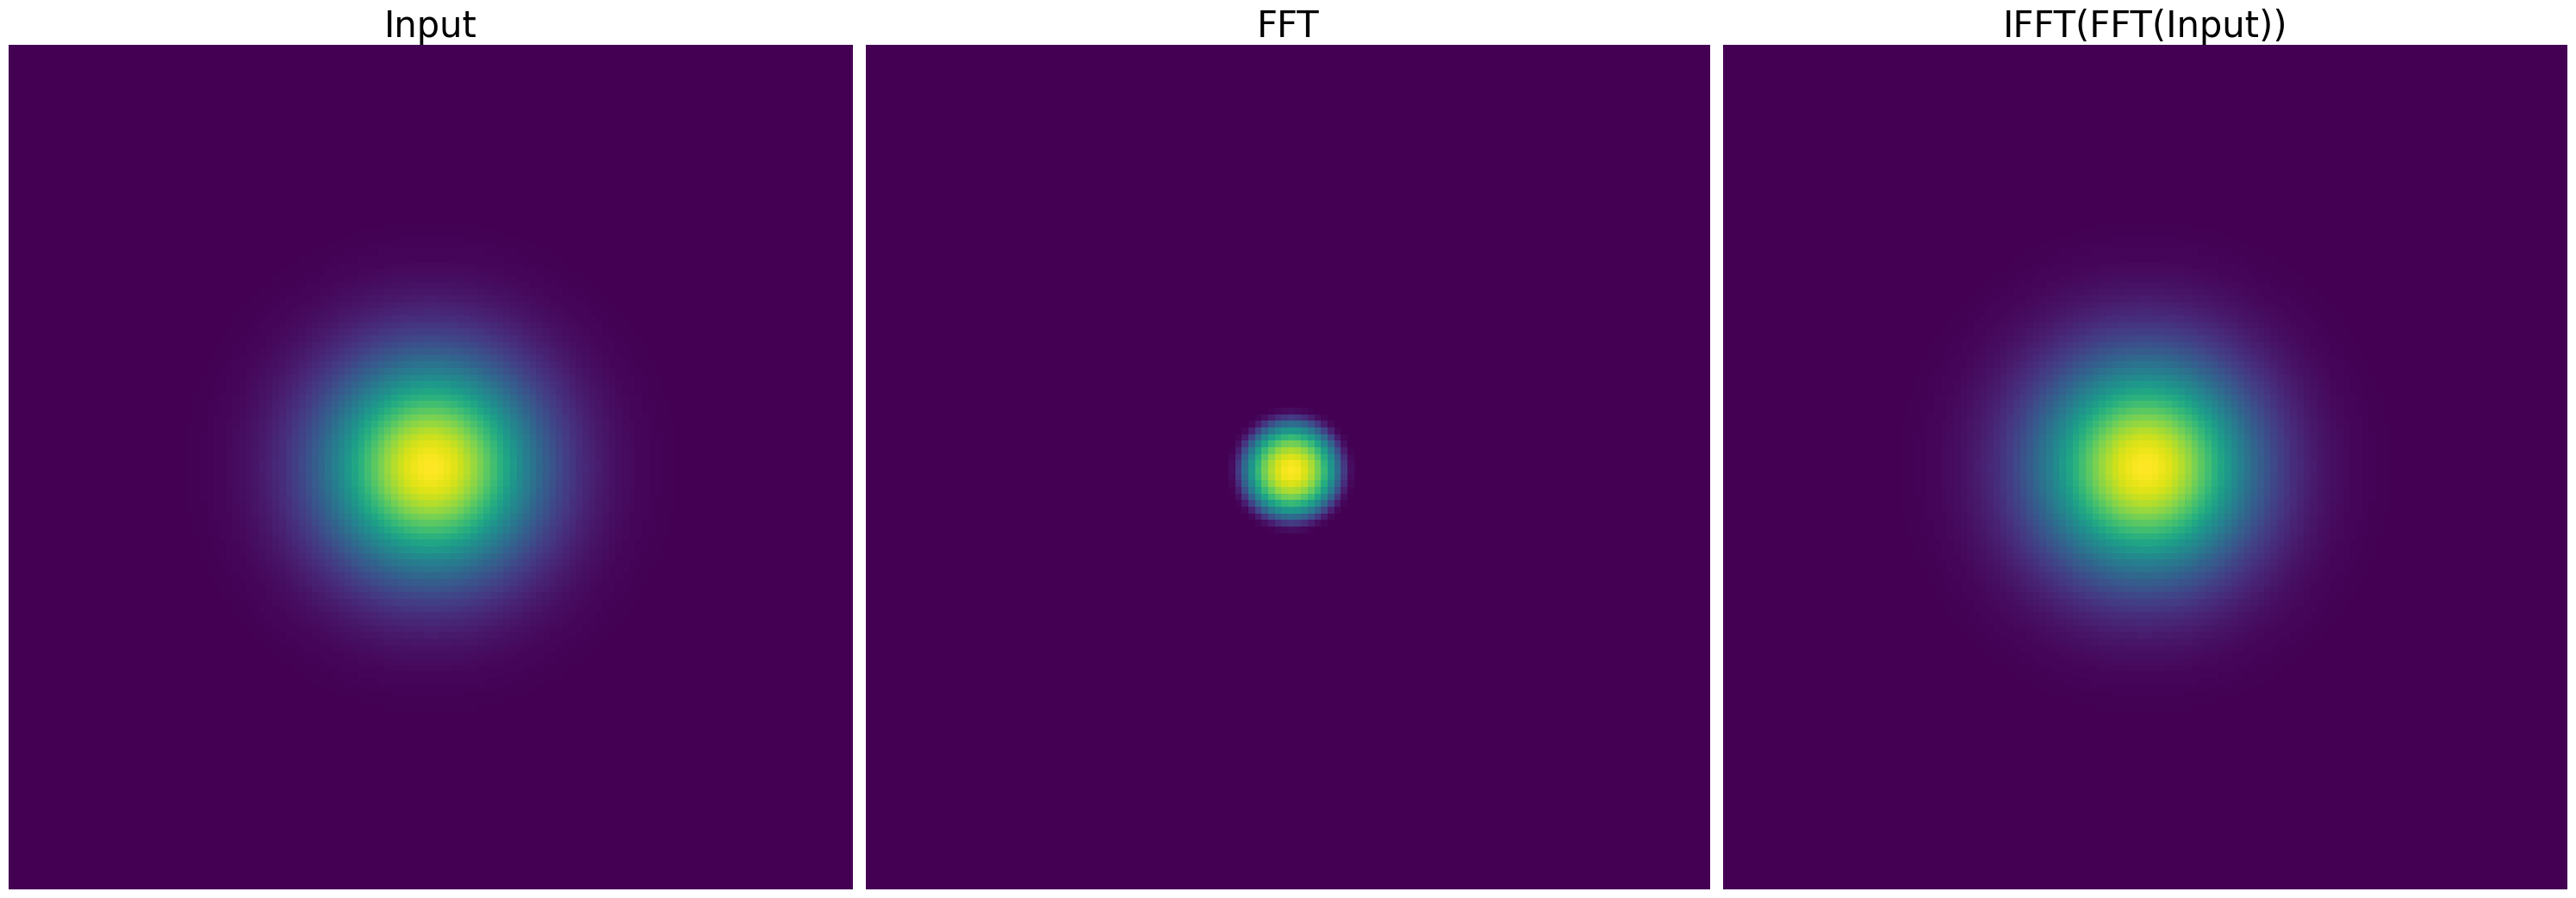

In [15]:
# Acts as the pre-sheared galaxy
round_gauss = create_gauss_gal(gal_flux=1.e5, 
                                   gal_sigma=2.0,
                                   psf_sigma=1.0, 
                                   pixel_scale=0.2)
visualize_FT(round_gauss)

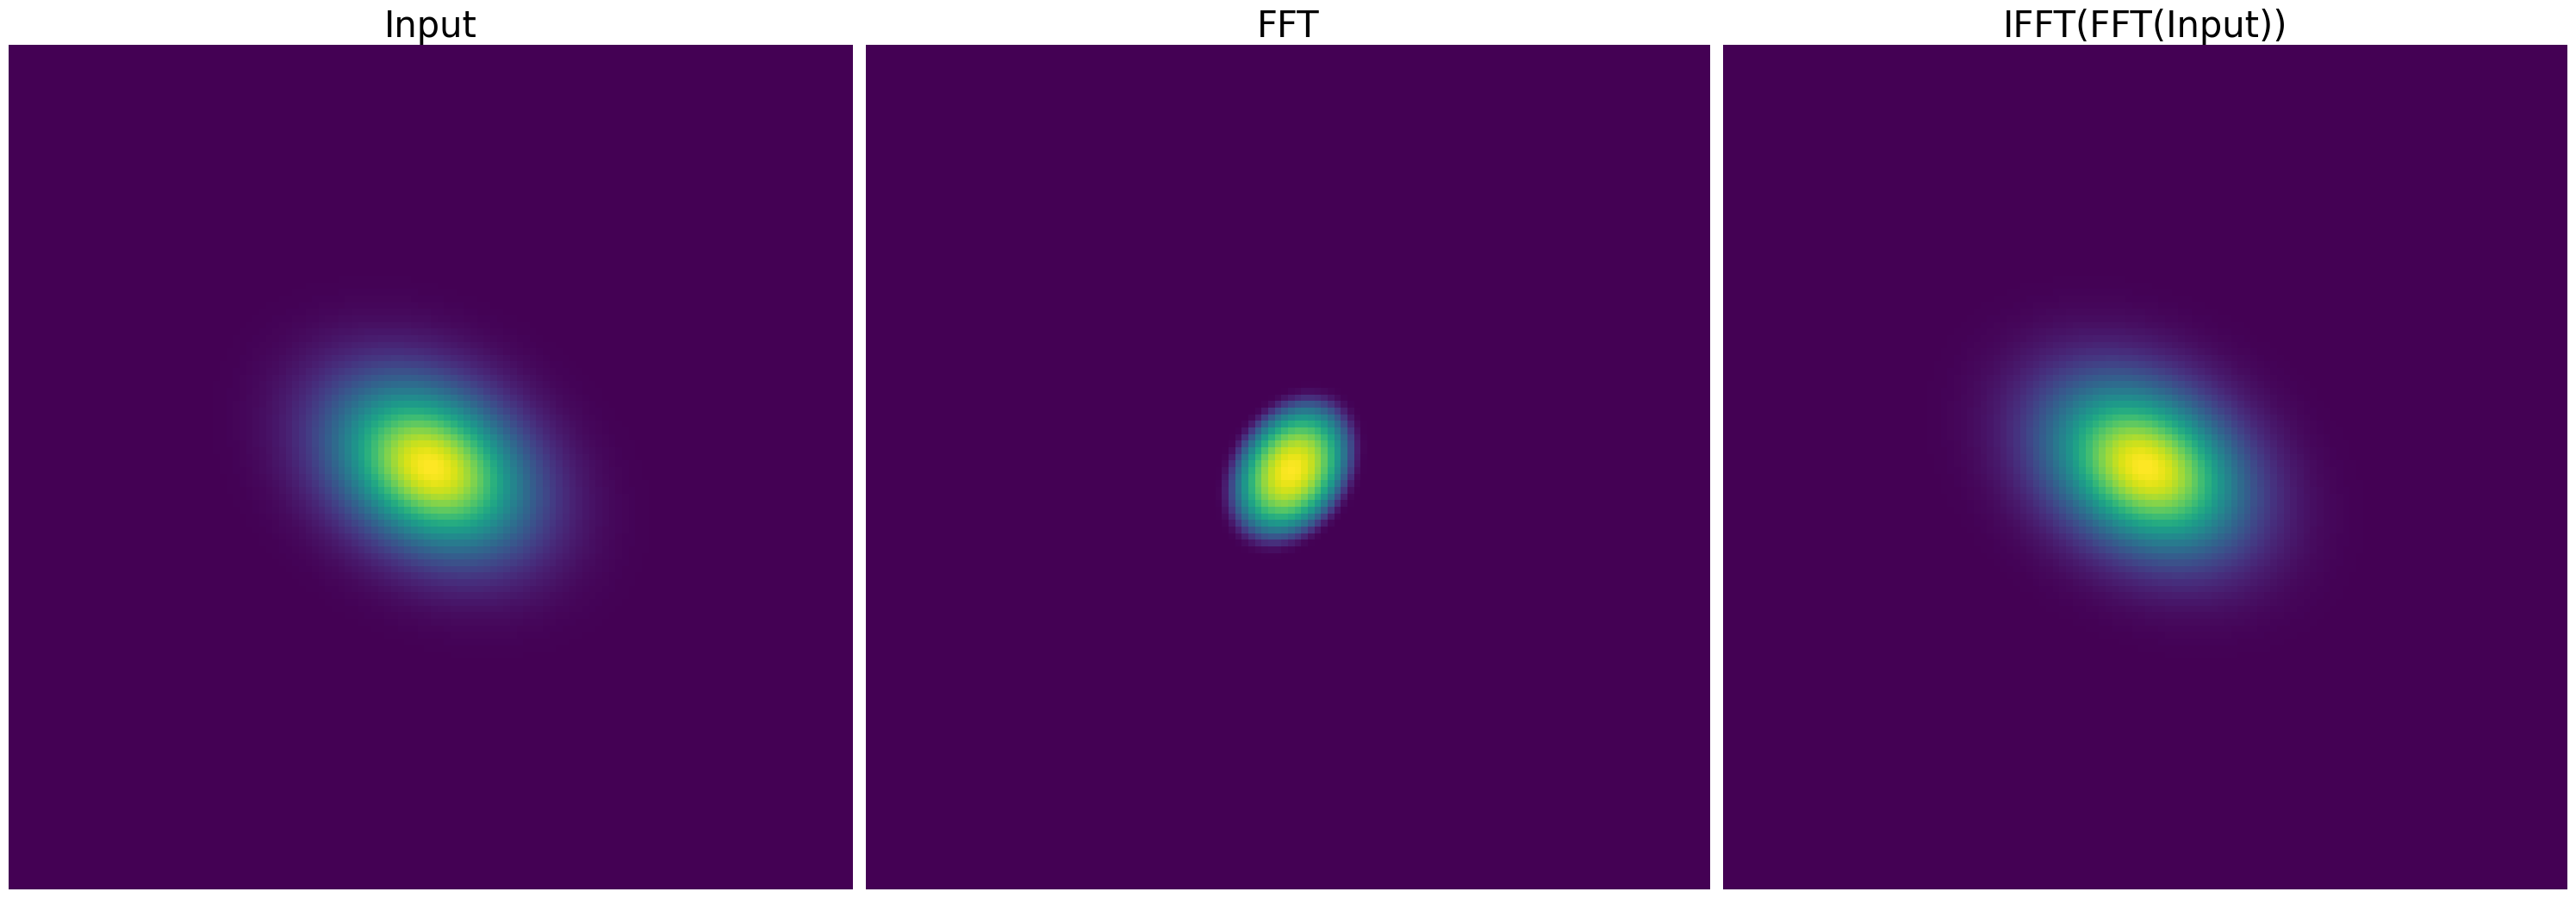

In [16]:
post_shear = create_gauss_gal(gal_flux=1.e5, 
                               gal_sigma=1.5,
                               psf_sigma=1.0, 
                               pixel_scale=0.2,
                               shear_on=True,
                               g1=0.1,
                               g2=0.2)
visualize_FT(post_shear)

So from doing the 2D FT Transform by hand we see the main points ie.:
1. The FT of a Gaussian is a Gaussian of reciprocal width. Meaning that if the input Gaussian is really spread out the FFT Gaussian will be really narrow and vice versa.
2. The flipping of the data in FT.

# 3. Noise effects of on Gaussians

In [17]:
# Acts as the pre-sheared galaxy
low_noise = create_gauss_gal(gal_flux=1.e5, 
                                   gal_sigma=2.0,
                                   psf_sigma=1.0, 
                                   pixel_scale=0.2,
                                   noise=10.,
                                   noise_on=True)

f_low, fshift_low, mag_low = FFT_IFFT_calc(img=low_noise, FFT=True)
ifft_low = FFT_IFFT_calc(img=fshift_low, FFT=False)


# Acts as the pre-sheared galaxy
high_noise = create_gauss_gal(gal_flux=1.e5, 
                                   gal_sigma=2.0,
                                   psf_sigma=1.0, 
                                   pixel_scale=0.2,
                                   noise=30.,
                                   noise_on=True)
f_high, fshift_high, mag_high = FFT_IFFT_calc(img=high_noise, FFT=True)
ifft_high = FFT_IFFT_calc(img=fshift_high, FFT=False)

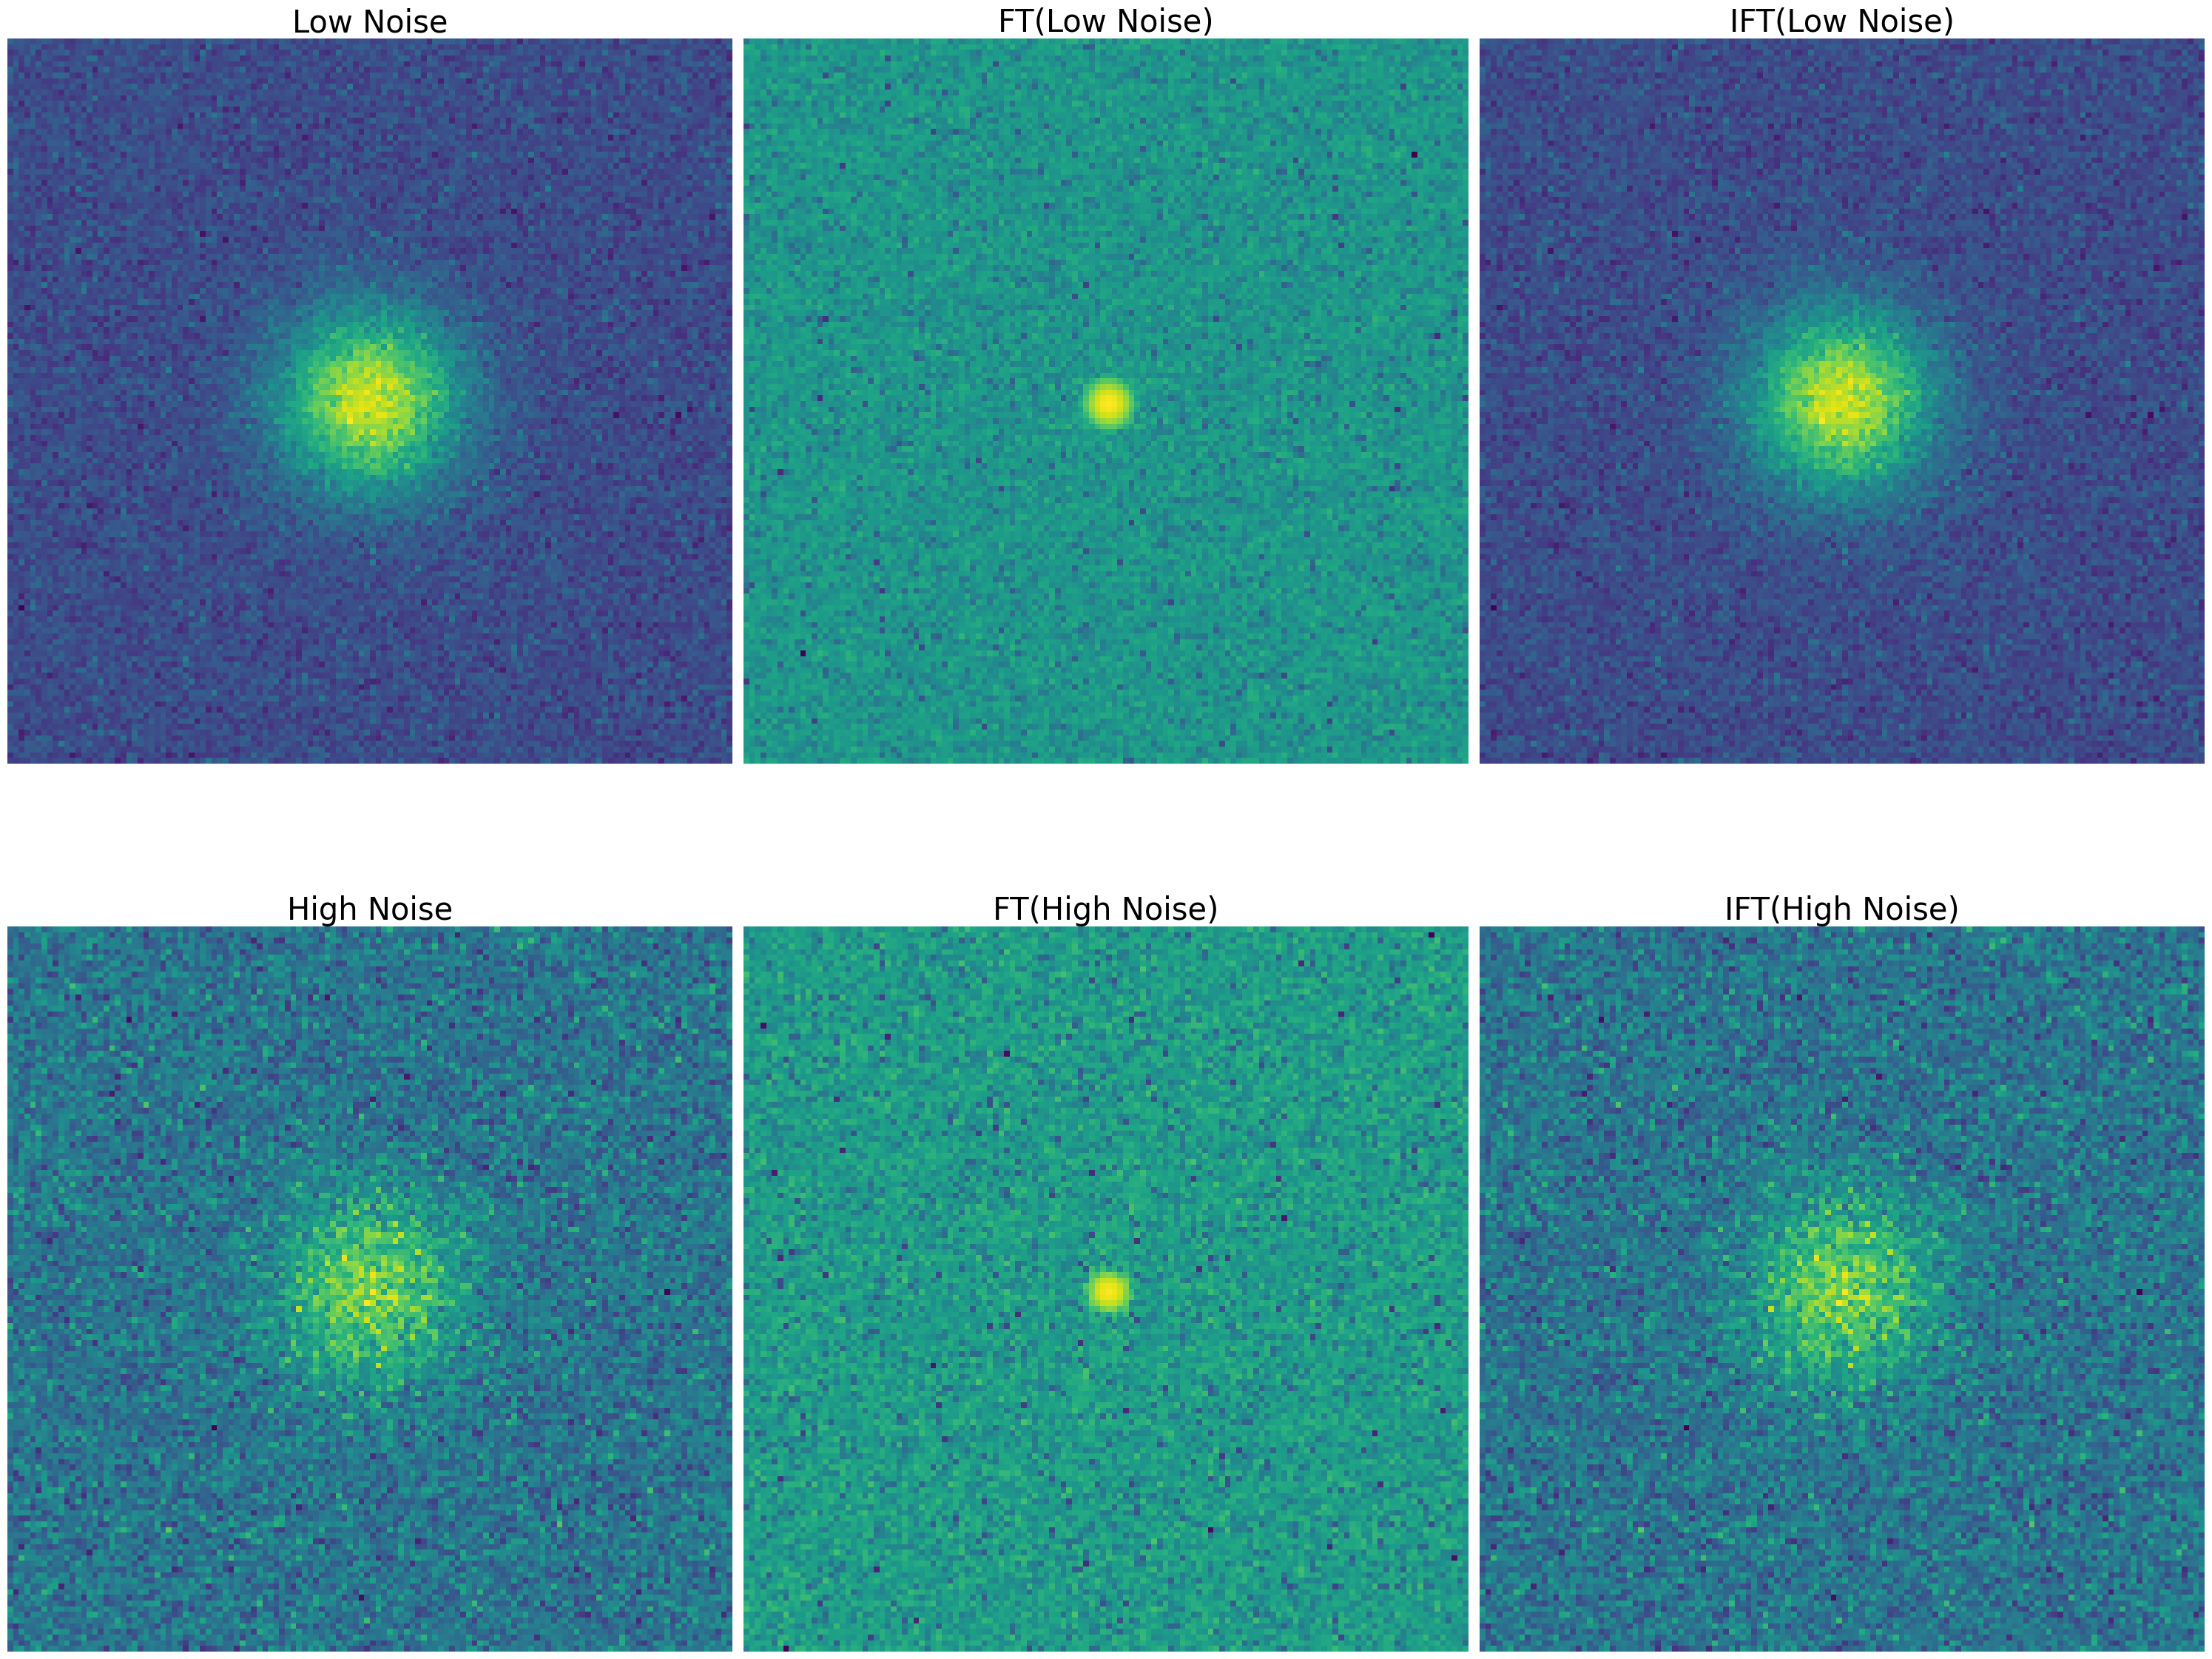

In [18]:
vmax_low = np.percentile(mag_low.real, (99))
vmin_low = -vmax_low

vmax_high = np.percentile(mag_high.real, (99))
vmin_high = -vmax_high


fig, axes = plt.subplots(2, 3, figsize=(30,26))
axes[0,0].imshow(low_noise)
axes[0,0].axis('off')
axes[0,0].set_title('Low Noise', fontsize=30)
axes[0,1].imshow(mag_low)
axes[0,1].axis('off')
axes[0,1].set_title('FT(Low Noise)', fontsize=30)
# axes[0,2].imshow(ifft_low.real, vmax=vmax_low, vmin=vmin_low)
axes[0,2].imshow(ifft_low.real)
axes[0,2].axis('off')
axes[0,2].set_title('IFT(Low Noise)', fontsize=30)
axes[1,0].imshow(high_noise)
axes[1,0].axis('off')
axes[1,0].set_title('High Noise', fontsize=30)
# axes[1,1].imshow(mag_high, vmax=vmax_high, vmin=vmin_high)
axes[1,1].imshow(mag_high)
axes[1,1].axis('off')
axes[1,1].set_title('FT(High Noise)', fontsize=30)
axes[1,2].imshow(ifft_high.real)
axes[1,2].axis('off')
axes[1,2].set_title('IFT(High Noise)', fontsize=30)


plt.tight_layout()
plt.show()

Sum of high noise image = 130541.4
Sum of low noise image = 112884.55


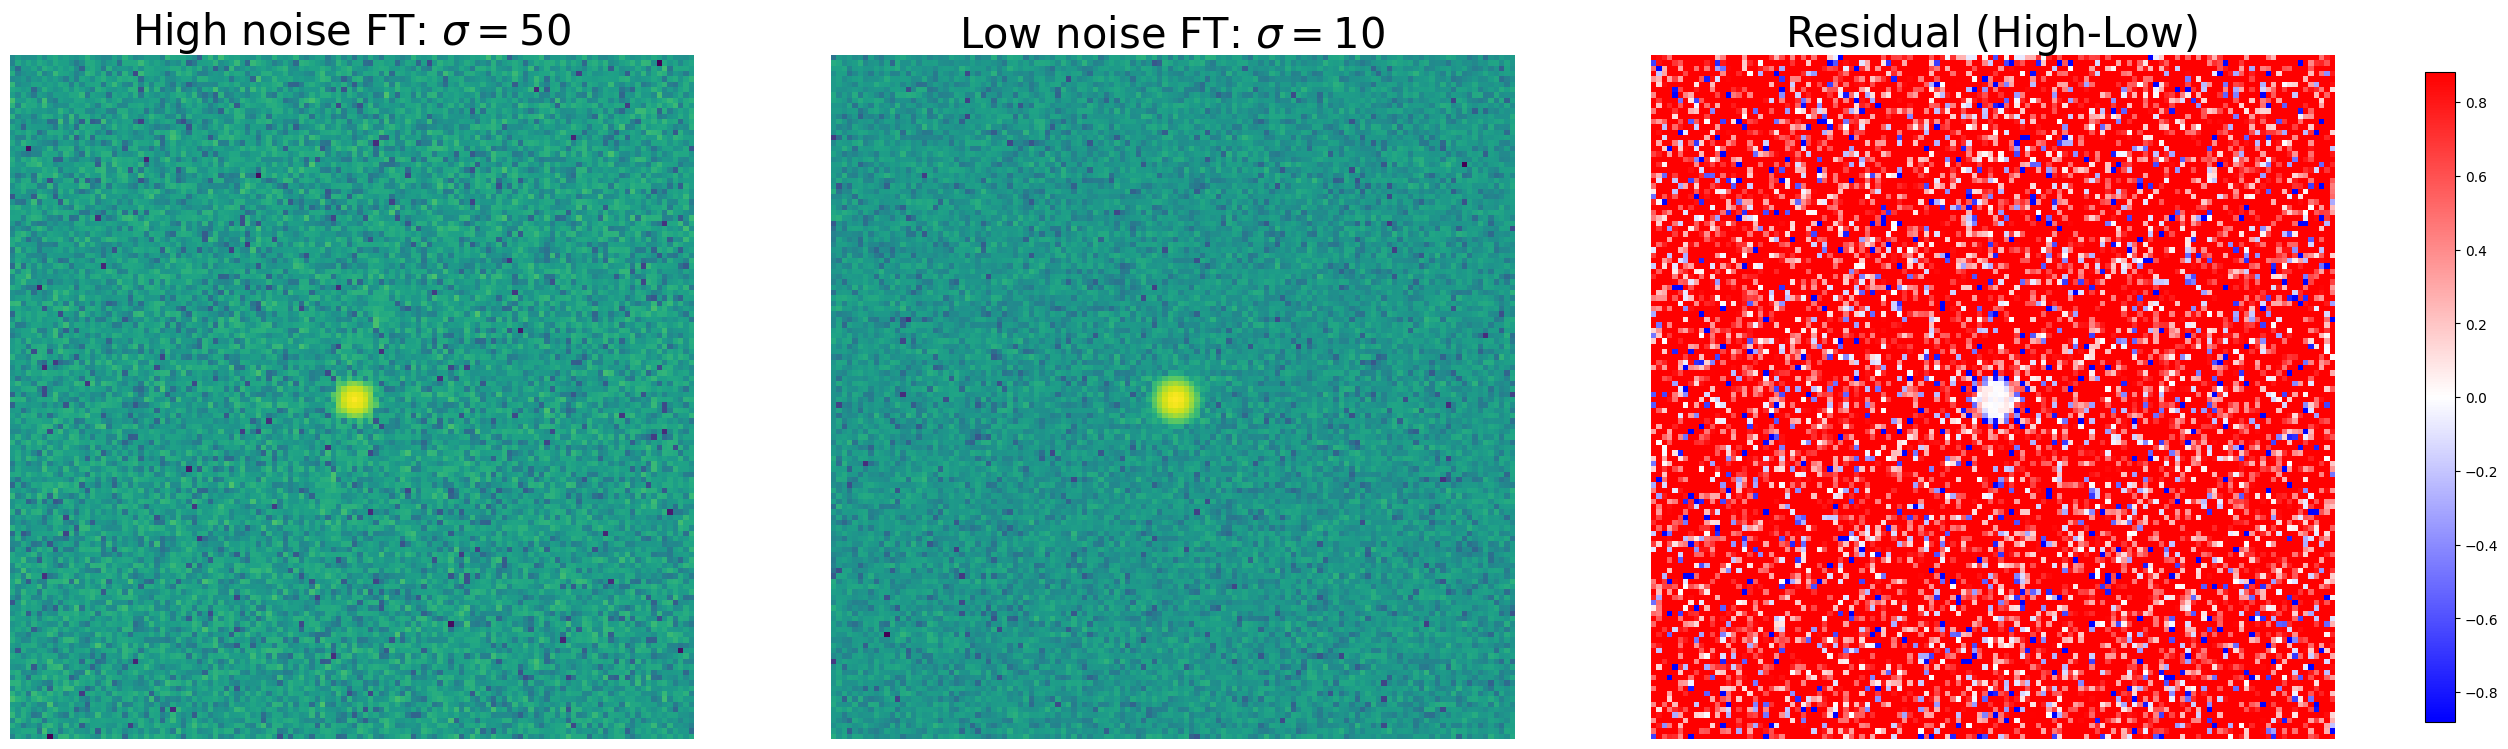

In [19]:
residual = mag_high - mag_low

fig, axes = plt.subplots(1, 3, figsize=(30,26), sharex=True, sharey=True)
axes[0].imshow(mag_high.real)
axes[0].axis('off')
axes[0].set_title('High noise FT: $\sigma = 50$', fontsize=30)
axes[1].imshow(mag_low.real)
axes[1].axis('off')
axes[1].set_title('Low noise FT: $\sigma = 10$', fontsize=30)
im = axes[2].imshow(residual.real,vmin=vmin, vmax=vmax, cmap='bwr')
axes[2].axis('off')
axes[2].set_title('Residual (High-Low)', fontsize=30)

cax = plt.axes([0.93, 0.37, 0.01, 0.25])
fig.colorbar(im, cax=cax, ax=axes[2])
print("Sum of high noise image =", np.sum(mag_high.real))
print("Sum of low noise image =", np.sum(mag_low.real))


# fig.tight_layout()
plt.show()